# Large Language Models can better predict optimal medication change in Parkinson's Disease through Medical notes

## Introduction

TODO

### Importing packages

In [1]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

## Data Pre-processing

### Exploring the data

In [2]:
path = "data/HEHE.csv" 
available_memory = 423464092  # Memory in bytes
memory_per_row = 100  # Example memory usage per row in bytes
target_memory_usage = 0.75 * available_memory
chunk_size = int(target_memory_usage / memory_per_row)
chunk_size

3175980

Original df that contains notes info

In [3]:
# Actual way to read large CSV files
chunk = pd.read_csv(path, chunksize=chunk_size, dtype={'dose_unit_source_value': str}) #Raises a DtypeWarning: Columns (11) have mixed types when it is not specified
df = pd.concat(chunk)

DataFrame with drug_exposure info

In [4]:
drug_exposure = pd.read_csv('data/TRY.csv')

Loading demographic info

In [5]:
demographics = pd.read_csv('data/DEMOGRAPHICS.csv') # Demographic information for PD patients only
demographics_all = pd.read_csv('data/DEMOGRAPHICS_ALL.csv') # Demographics info for all the patients

In [6]:
df.sample(5)

,person_id,drug_source_value,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
2044509,202164,"{""med_display_name"": ""bacitracin injection"", ""...",10.00,PRN IN OR,NaN,50000.0,Units,"""[**NAME**], DO [**DATE**] 1:39 PM Depart..."
2015950,205200,"{""med_display_name"": ""TPN with insulin regular...",75.00,Continuous start 2000,INTRAVENOUS,75.0,ml/hr,"""[**NAME**], MD [**DATE**] 7:10 AM Dept o..."
793485,254942,"{""med_display_name"": ""amiodarone (CORDARONE) 9...",0.37,CONTINUOUS,INTRAVENOUS,0.5,mg/min,"[**NAME**], MD [**DATE**] 11:22 PM Patient..."
1141071,248403,"{""med_display_name"": ""olopatadine (PATANOL) 0....",0.05,2 TIMES DAILY,BOTH EYES,1.0,drop,[**NAME**] [**DATE**] 3:36 PM Palliative ...
1778561,215778,"{""med_display_name"": ""docusate sodium (COLACE)...",0.00,NIGHTLY,ORAL,0.0,mg,"""[**NAME**], MD [**DATE**] 4:22 PM Depart..."


Calculating patient age

In [7]:
# Converting the "birth_datetime" column to a datetime format 
demographics["birth_datetime"] = pd.to_datetime(demographics["birth_datetime"], format='%Y-%m-%d')
demographics_all["birth_datetime"] = pd.to_datetime(demographics_all["birth_datetime"], format='%Y-%m-%d')

# Calculating the age by substracting the current date with the date in the dataframe
demographics["age"] = (pd.Timestamp('now') - demographics["birth_datetime"]).astype('timedelta64[Y]')
demographics_all["age"] = (pd.Timestamp('now') - demographics_all["birth_datetime"]).astype('timedelta64[Y]')

# Converting age to integer
demographics["age"]  = pd.to_numeric(demographics["age"], downcast='integer')
demographics_all["age"]  = pd.to_numeric(demographics_all["age"], downcast='integer')

# Dropping the birth_datetime (it's useless at this point) 
demographics = demographics.drop("birth_datetime", axis=1)
demographics_all = demographics_all.drop("birth_datetime", axis=1)

# Re-arranging the order of the columns
demographics = demographics[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]
demographics_all = demographics_all[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]

demographics

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value
0,261006,74,MALE,WHITE,NOT HISPANIC
1,260996,76,FEMALE,WHITE,NOT HISPANIC
2,260956,88,FEMALE,WHITE,NOT HISPANIC
3,260918,79,FEMALE,WHITE,NOT HISPANIC
4,260872,74,MALE,BLACK,NOT HISPANIC
...,...,...,...,...,...
281,176706,78,FEMALE,WHITE,NOT HISPANIC
282,176462,68,MALE,WHITE,NOT HISPANIC
283,176417,77,MALE,WHITE,NOT HISPANIC
284,175744,90,MALE,WHITE,NOT HISPANIC


Actual len of the whole dataset. It has more than 2 Million rows

In [8]:
len(df)

2326300

#### Number of patients in this cohort

In [9]:
df['person_id'].nunique()

441

#### Dealing with the drug_source_value column

Because the drug_source_value column contains elements as json, we convert them into a dict so that we can use their original keys:

In [10]:
drug_source_value = df['drug_source_value'].apply(lambda x: json.loads(x))

We do the same for the `drug_source_value` column in the drug_exposure database

In [11]:
dsv_drug_exposure = drug_exposure['drug_source_value'].apply(lambda x: json.loads(x))

dsv_drug_exposure has already been filtered through SQL and contains Parkinson's drugs

In [12]:
dsv_drug_exposure

0        {'med_display_name': 'carbidopa-levodopa (SINE...
1        {'med_display_name': 'carbidopa-levodopa (SINE...
2        {'med_display_name': 'carbidopa-levodopa (SINE...
3        {'med_display_name': 'carbidopa-levodopa (SINE...
4        {'med_display_name': 'carbidopa-levodopa (SINE...
                               ...                        
26941    {'med_display_name': 'carbidopa-levodopa (SINE...
26942    {'med_display_name': 'carbidopa-levodopa (SINE...
26943    {'med_display_name': 'carbidopa-levodopa (SINE...
26944    {'med_display_name': 'carbidopa-levodopa (SINE...
26945    {'med_display_name': 'carbidopa-levodopa (SINE...
Name: drug_source_value, Length: 26946, dtype: object

drug_source_value has the same len as the original df. The positions of the dictionary are the rows in the OG df 

In [13]:
drug_source_value[12] == json.loads(df.iloc[12]['drug_source_value'])

True

The keys of the dictionary are those used in the drug_source_value column

In [14]:
drug_source_value[0].keys()

dict_keys(['med_display_name', 'rxnorm_concat', 'med_dose_unit_desc', 'mar_action', 'med_order_desc'])

In [15]:
drug_source_value[12]

{'med_display_name': '0.9 % NaCl infusion',
 'rxnorm_concat': '| 313002 |',
 'med_dose_unit_desc': 'ml/hr',
 'mar_action': 'NEW BAG',
 'med_order_desc': 'SODIUM CHLORIDE 0.9 % IV SOLN'}

Current medication used for the treatment of Parkinson's disease

In [16]:
# Defining the generic name of drugs used to treat Parkinson's disease
pd_medication = ["carbidopa", "levodopa", "entacapone", "tolcapone", "opicapone", "pramipexole", "ropinirole", "apomorphine", "rotigotine", "selegiline", "rasagiline", "safinamide", "amantadine", "istradefylline", "trihexyphenidyl", "benztropine", "bromocriptine", "cabergoline", "pergolide", "lisuride"]

We look for instances of the Parkinson's drugs contained in the pd_medication array in drug_source_value so that we can focus on the medical notes relating to Parkinson's.

In [17]:
pd_drug_info = {}
for i, drug in enumerate(drug_source_value):
    for item in pd_medication:
        # I'm still not sure why I can use drug as a dict here. Answer because drug_source_value is a dict
        if item in drug['med_display_name']:
            pd_drug_info[i] = drug['med_display_name'] # I could have also passed the whole dictionary

Something similar (extracting the med_display_name and using that instead of the whole json)

In [18]:
drug_info_drug_source_value = {}
for i, drug in enumerate(dsv_drug_exposure):
    drug_info_drug_source_value[i] = drug['med_display_name'] # I could have also passed the whole dictionary

In [19]:
pd_drug_info

{126: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 127: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 955: 'amantadine (SYMMETREL) capsule 100 mg',
 956: 'amantadine (SYMMETREL) capsule 100 mg',
 957: 'amantadine (SYMMETREL) capsule 100 mg',
 958: 'amantadine (SYMMETREL) capsule 100 mg',
 959: 'amantadine (SYMMETREL) capsule 100 mg',
 960: 'amantadine (SYMMETREL) capsule 100 mg',
 961: 'amantadine (SYMMETREL) capsule 100 mg',
 962: 'amantadine (SYMMETREL) capsule 100 mg',
 963: 'amantadine (SYMMETREL) capsule 100 mg',
 964: 'amantadine (SYMMETREL) capsule 100 mg',
 965: 'amantadine (SYMMETREL) capsule 100 mg',
 966: 'amantadine (SYMMETREL) capsule 100 mg',
 967: 'amantadine (SYMMETREL) capsule 100 mg',
 968: 'amantadine (SYMMETREL) capsule 100 mg',
 969: 'amantadine (SYMMETREL) capsule 100 mg',
 970: 'amantadine (SYMMETREL) solution 100 mg',
 971: 'amantadine (SYMMETREL) solution 100 mg',
 972: 'amantadine (SYMMETREL) solution 100 mg',
 973: 'amantadi

In [20]:
drug_info_drug_source_value

{0: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 2: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 3: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 4: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 5: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 6: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 7: 'amantadine (SYMMETREL) capsule 100 mg',
 8: 'amantadine (SYMMETREL) capsule 100 mg',
 9: 'amantadine (SYMMETREL) capsule 100 mg',
 10: 'amantadine (SYMMETREL) capsule 100 mg',
 11: 'amantadine (SYMMETREL) capsule 100 mg',
 12: 'amantadine (SYMMETREL) capsule 100 mg',
 13: 'amantadine (SYMMETREL) capsule 100 mg',
 14: 'amantadine (SYMMETREL) capsule 100 mg',
 15: 'amantadine (SYMMETREL) capsule 100 mg',
 16: 'amantadine (SYMMETREL) capsule 100 mg',
 17: 'amantadine (SYMMETREL) capsule 100 mg',
 18: 'amantadine (SYMMETREL) capsul

Only 16K+ rows have information regarding medication for Parkinson's

In [21]:
len(pd_drug_info)

16040

The keys of this new array are the indices or rows in the original DataFrame. These rows contain information regarding Parkinson's medication 

In [22]:
pd_drug_info.keys()

dict_keys([126, 127, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 2353, 2354, 2355, 2438, 2439, 2521, 2522, 2523, 2524, 2525, 2706, 2707, 2708, 2709, 2710, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 3496, 3497, 3498, 3499, 3500, 3501, 350

pd_drug_info is a subset of drug_source_value that contains the name of drugs related to PD

In [23]:
pd_drug_info[1299166]

'cabergoline (DOSTINEX) tablet 1 mg'

In [24]:
drug_source_value[1299166]

{'med_display_name': 'cabergoline (DOSTINEX) tablet 1 mg',
 'rxnorm_concat': '| 199703 |',
 'med_dose_unit_desc': 'mg',
 'mar_action': 'GIVEN',
 'med_order_desc': 'CABERGOLINE 0.5 MG PO TABS'}

Here's our new database. df_pd is a subset of the original dataset that only contains patients that are taking medication for Parkinson's

In [25]:
df_pd = df.iloc[list(pd_drug_info.keys())]
df_pd.sample(10)

,person_id,drug_source_value,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
897429,252405,"{""med_display_name"": ""amantadine (SYMMETREL) c...",0.0,2 TIMES DAILY,ORAL,0.0,mg,"[**NAME**], RN [**DATE**] 3:30 PM Consult..."
1777185,215778,"{""med_display_name"": ""carbidopa-levodopa (SINE...",0.0,Every 3 hours while awake,ORAL,0.0,tablet,"""[**NAME**], MD [**DATE**] 11:01 AM Depart..."
2000569,205200,"{""med_display_name"": ""amantadine (SYMMETREL) c...",1.0,2 TIMES DAILY,ORAL,100.0,mg,"[**NAME**], MD [**DATE**] 10:12 PM Departm..."
2051937,202019,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,3 TIMES DAILY,PER G TUBE,2.0,tablet,"""[**NAME**], MD [**DATE**] 7:18 PM [**DAT..."
664750,256706,"{""med_display_name"": ""benztropine (COGENTIN) t...",1.0,2 TIMES DAILY,ORAL,1.0,mg,"""[**NAME**], DO [**DATE**] 2:42 AM Depart..."
91274,257440,"{""med_display_name"": ""carbidopa-levodopa (SINE...",0.0,2 TIMES DAILY,ORAL,0.0,tablet,[**NAME**] [**DATE**] 10:13 AM Palliative ...
1122289,248836,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,NIGHTLY,ORAL,2.0,tablet,"[**NAME**], MD [**DATE**] 3:06 PM Tranfer..."
1776989,215778,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,4 TIMES DAILY PRN,ORAL,1.0,tablet,"[**NAME**], DO [**DATE**] 12:47 PM Neurolo..."
2250748,186338,"{""med_display_name"": ""carbidopa-levodopa (SINE...",3.0,3 TIMES DAILY,ORAL,3.0,tablet,"""[**NAME**] [**DATE**] 10:38 PM Rehab Psyc..."
2087248,201132,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,3 TIMES DAILY,ORAL,1.0,tablet,"[**NAME**], MSW [**DATE**] 3:02 PM SW Con..."


Inserting the column drug_info into the pd dataset

In [26]:
df_pd.insert(loc=2, column="drug_info", value=drug_info_drug_source_value)

In [27]:
df_pd.sample(5)

,person_id,drug_source_value,drug_info,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
1797861,213780,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,0.0,3 TIMES DAILY,ORAL,0.0,tablet,"[**NAME**], MD [**DATE**] 4:17 PM MICU Ev..."
664681,256706,"{""med_display_name"": ""benztropine (COGENTIN) t...",NaN,1.0,2 TIMES DAILY,ORAL,1.0,mg,"""[**NAME**], APRN [**DATE**] 2:13 PM Depa..."
1122284,248836,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,0.0,NIGHTLY,ORAL,0.0,tablet,[**NAME**] [**DATE**] 6:20 PM Consult rec...
1439514,220757,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,0.5,2 TIMES DAILY,ORAL,0.5,tablet,"""[**NAME**], MD [**DATE**] 9:14 AM Depart..."
1200662,245632,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",NaN,0.0,3 TIMES DAILY,ORAL,0.0,mg,[**NAME**] [**DATE**] 1:53 PM Order ackno...


In [28]:
df_pd.iloc[955]

person_id                                                            257075
drug_source_value         {"med_display_name": "carbidopa-levodopa (SINE...
drug_info                                                               NaN
quantity                                                                0.5
sig                                                           4 TIMES DAILY
route_source_value                                                     ORAL
dose_source_value                                                       0.5
dose_unit_source_value                                               tablet
note_text                 "[**NAME**], MD     [**DATE**]  9:56 PM [**LOC...
Name: 92436, dtype: object

Let's take a look at the drugs actually used in the dataset. **Note**: vscode truncakes the ouput so it could be that you won't see all the drugs. i.e: Cabergoline (1299166).

In [29]:
pd_drug_info

{126: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 127: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 955: 'amantadine (SYMMETREL) capsule 100 mg',
 956: 'amantadine (SYMMETREL) capsule 100 mg',
 957: 'amantadine (SYMMETREL) capsule 100 mg',
 958: 'amantadine (SYMMETREL) capsule 100 mg',
 959: 'amantadine (SYMMETREL) capsule 100 mg',
 960: 'amantadine (SYMMETREL) capsule 100 mg',
 961: 'amantadine (SYMMETREL) capsule 100 mg',
 962: 'amantadine (SYMMETREL) capsule 100 mg',
 963: 'amantadine (SYMMETREL) capsule 100 mg',
 964: 'amantadine (SYMMETREL) capsule 100 mg',
 965: 'amantadine (SYMMETREL) capsule 100 mg',
 966: 'amantadine (SYMMETREL) capsule 100 mg',
 967: 'amantadine (SYMMETREL) capsule 100 mg',
 968: 'amantadine (SYMMETREL) capsule 100 mg',
 969: 'amantadine (SYMMETREL) capsule 100 mg',
 970: 'amantadine (SYMMETREL) solution 100 mg',
 971: 'amantadine (SYMMETREL) solution 100 mg',
 972: 'amantadine (SYMMETREL) solution 100 mg',
 973: 'amantadi

In [30]:
# pd_drugs_used is just the list version of lowercase values in pd_drug_info
pd_drugs_used = [item.lower() for item in pd_drug_info.values()]
# Takes the unique values and sorts them to finally be saved in an array
pd_drugs_used_unique = sorted(set(pd_drugs_used))

We do the same for the drugs in dsv_drug_exposure

In [31]:
drugs_used_drug_exposure = [item.lower() for item in drug_info_drug_source_value.values()]
drugs_used_drug_exposure_unique = sorted(set(drugs_used_drug_exposure))

In [32]:
drugs_used_drug_exposure_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 36.25-145 mg cpcr 1 capsule-patient supplied med',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied med ',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel

**Note:** 1299166 is **NOT** the position in the array but rather the key that contains the element. The len for both structures in 16040  

In [33]:
pd_drug_info[1299166]

'cabergoline (DOSTINEX) tablet 1 mg'

The position in the list that contains item with the key 1299166

In [34]:
list(pd_drug_info.keys()).index(1299166)

7778

In [35]:
pd_drugs_used

['carbidopa-levodopa (sinemet) 25-100 mg per tablet 2 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 2 tablet',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'benztropine (cogentin) tabl

In [36]:
pd_drugs_used_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 200 mg',
 'amantadine (symmetrel) solution 50 mg',
 'amantadine (symmetrel) syrup 100 mg',
 'amantadine (symmetrel) syrup 50 mg',
 'amantadine er (gocovri) extended release capsule 137 mg',
 'apomorphine (apokyn) injection 1 ml',
 'benztropine (cogentin) tablet 0.5 mg',
 'benztropine (cogentin) tablet 1 mg',
 'benztropine (cogentin) tablet 2 mg

In [37]:
drugs_used_drug_exposure_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 36.25-145 mg cpcr 1 capsule-patient supplied med',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied med ',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel

Using a ***Regex*** to segment from the pd_drugs_used array the drug_name, generic_name and dosage

In [38]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names = []
brand_names = []
dosages = []

# Extract information and populate the lists
for string in pd_drugs_used:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names.append(generic_name)

        if brand_name:
            brand_names.append(brand_name)
        else:
            brand_names.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages.append(dosage_match[0])
        else:
            dosages.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names.append(np.nan)


# Create DataFrame
pd_data = pd.DataFrame({
    "generic_name": generic_names,
    "brand_name": brand_names,
    "dosage": dosages
})

*Regex* for drug_exposure

In [39]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names_de = []
brand_names_de = []
dosages_de = []

# Extract information and populate the lists
for string in drugs_used_drug_exposure:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names_de.append(generic_name)

        if brand_name:
            brand_names_de.append(brand_name)
        else:
            brand_names_de.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages_de.append(dosage_match[0])
        else:
            dosages_de.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names_de.append(np.nan)


# Create DataFrame
pd_data_drug_exposure = pd.DataFrame({
    "generic_name": generic_names_de,
    "brand_name": brand_names_de,
    "dosage": dosages_de
})

In [40]:
pd_data.sample(20)

,generic_name,brand_name,dosage
10726,carbidopa-levodopa,sinemet,25-100 mg
8176,carbidopa-levodopa,sinemet,10-100 mg
12819,carbidopa-levodopa,sinemet,25-100 mg
12468,pramipexole,mirapex,1 mg
13872,amantadine,symmetrel,100 mg
9983,pramipexole,mirapex,0.25 mg
9225,carbidopa-levodopa,sinemet cr,25-100 mg
1267,carbidopa-levodopa,sinemet cr,25-100 mg
4260,carbidopa-levodopa,sinemet,25-100 mg
9832,carbidopa-levodopa,sinemet,25-100 mg


In [41]:
pd_data_drug_exposure.sample(20)

,generic_name,brand_name,dosage
26739,carbidopa-levodopa,sinemet,25-100 mg
22161,carbidopa-levodopa,sinemet,25-100 mg
10374,carbidopa-levodopa,sinemet,25-100 mg
15206,carbidopa-levodopa,sinemet,25-100 mg
2117,carbidopa-levodopa,sinemet,25-100 mg
15993,ropinirole,requip,4 mg
6093,benztropine,cogentin,2 mg
26869,carbidopa-levodopa,sinemet,12.5-50 mg
20667,ropinirole,requip,0.5 mg
1542,carbidopa-levodopa,sinemet,25-100 mg


Error or inconsistency. I might look into this later

In [42]:
# There's an inconsistency with this. The RxCUI code associated with it (885205) actually shows 1 mg not 0.5. See: https://mor.nlm.nih.gov/RxNav/search?searchBy=RXCUI&searchTerm=885205
df_pd['drug_source_value'].iloc[3013]

'{"med_display_name": "benztropine mesylate (COGENTIN) injection 0.5 mg", "rxnorm_concat": "| 885205 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "BENZTROPINE MESYLATE 1 MG/ML IJ SOLN"}'

In [43]:
pd_data.iloc[3013]

generic_name    benztropine mesylate
brand_name                  cogentin
dosage                        0.5 mg
Name: 3013, dtype: object

In [44]:
# Notice that for selegiline the generic_name still contains the dosage and form of administration. This is because, for selegiline, the name string doesn't contain the brand name   
pd_data.iloc[13628]

generic_name    selegiline tablet 5 mg
brand_name                         NaN
dosage                            5 mg
Name: 13628, dtype: object

#### Dealing with missing data

In [45]:
# Taking a look at the rows where there are missing values 
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name         dosage
3333               carbidopa-levodopa patient own        NaN            NaN
3334               carbidopa-levodopa patient own        NaN            NaN
3335               carbidopa-levodopa patient own        NaN            NaN
5187                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5188                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5189                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5190                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5191                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5192                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5193                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5194                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5195                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5196        

Using the pd_drugs_used_unique list to fill missing values que realize that the brand name for the drug is actualy duopa

In [46]:
pd_drugs_used[5187:5199]

['**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med']

In [47]:
# Duopa is a carbodipa-levodopa intestinal gel used for PD
pd_drugs_used[7346:7390]

['inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodo

In [48]:
# Regex couldn't catch the brand name because it was in a different position, so we add it manually
pd_data.loc[pd_data.index[5187:5199], 'brand_name'] = 'duopa'
# Patient is taking LCIG (Levodopa-cabidopa intestinal gel), most likely it is duopa (this is an assumption) -> It's actually true
# TODO: Maybe replace this with Dopamine Replacement Therapy (Listen again to Dr. K's audio)
pd_data.loc[pd_data.index[7346:7390], 'brand_name'] = 'duopa'
# pd_data.loc[pd_data.index[7712:7725], 'brand_name'] = 'duopa' #durg_exposure_file

In [49]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name dosage
3333               carbidopa-levodopa patient own        NaN    NaN
3334               carbidopa-levodopa patient own        NaN    NaN
3335               carbidopa-levodopa patient own        NaN    NaN
7368   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7369   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7370   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7371   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7372   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7373   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7374   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7375   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7376   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7377   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7378   inv levodopa-carbidopa intestinal gel pum

Looking for evidence of other brand names for Selegiline in our database

In [50]:
selegiline = pd_data[(pd_data['brand_name'] == 'eldepryl')| (pd_data['brand_name'] == 'zelapar')]
selegiline['brand_name'].unique()

array(['eldepryl'], dtype=object)

In [51]:
print(selegiline.to_string())

      generic_name brand_name dosage
432     selegiline   eldepryl   5 mg
433     selegiline   eldepryl   5 mg
434     selegiline   eldepryl   5 mg
435     selegiline   eldepryl   5 mg
436     selegiline   eldepryl   5 mg
437     selegiline   eldepryl   5 mg
438     selegiline   eldepryl   5 mg
439     selegiline   eldepryl   5 mg
440     selegiline   eldepryl   5 mg
441     selegiline   eldepryl   5 mg
442     selegiline   eldepryl   5 mg
443     selegiline   eldepryl   5 mg
444     selegiline   eldepryl   5 mg
445     selegiline   eldepryl   5 mg
446     selegiline   eldepryl   5 mg
447     selegiline   eldepryl   5 mg
6110    selegiline   eldepryl   5 mg
7594    selegiline   eldepryl   5 mg
7595    selegiline   eldepryl   5 mg
7596    selegiline   eldepryl   5 mg
13507   selegiline   eldepryl   5 mg
13508   selegiline   eldepryl   5 mg
13509   selegiline   eldepryl   5 mg
13510   selegiline   eldepryl   5 mg
13511   selegiline   eldepryl   5 mg
13512   selegiline   eldepryl   5 mg
1

Making sure the word "tablet" isn't present in the drug's generic name


In [52]:
for index, name in enumerate(generic_names): #This one refers to drug_exposure
    if 'tablet' in name:
        print(name, index)

selegiline tablet 5 mg 13628
selegiline tablet 5 mg 13629
selegiline tablet 5 mg 13630
selegiline tablet 5 mg 13631
selegiline tablet 5 mg 13632
selegiline tablet 5 mg 13633
selegiline tablet 5 mg 13634
selegiline tablet 5 mg 13635
selegiline tablet 5 mg 13636
selegiline tablet 5 mg 13637
selegiline tablet 5 mg 13638
selegiline tablet 5 mg 13639


Blindfully assuming that the medication taken by the patient was in fact eldepryl. TODO: Listen again to an audio and check for DPT (Dopamine replacement Therapy)

In [53]:
pd_data.loc[pd_data.index[13628:13640], 'brand_name'] = 'eldepryl'
# Replacing "selegiline tablet 5mg for just selegiline"
pd_data.loc[pd_data.index[13628:13640], 'generic_name'] = 'selegiline'

TODO: For "carbidopa-levodopa patient own med" we aren't sure about the medication (sinemet, sinemet cr, etc) let's look at the rxnorm codes to see if they are informative

In [54]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                    generic_name brand_name dosage
3333              carbidopa-levodopa patient own        NaN    NaN
3334              carbidopa-levodopa patient own        NaN    NaN
3335              carbidopa-levodopa patient own        NaN    NaN
7368  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7369  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7370  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7371  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7372  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7373  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7374  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7375  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7376  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7377  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7378  inv levodopa-carbidopa intestinal gel pump      duopa   

In [55]:
missing_info_index = pd_data[pd_data.isnull().any(axis=1)].index

In [56]:
for i in range(len(missing_info_index)):
    print(df_pd.iloc[missing_info_index[i]]['drug_source_value'])

{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
{"med_display_name": "Inv levodopa-carbidopa intestinal gel pump stop", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "each", "mar_action": "GIVEN BY OTHER", "med_order_desc": "INV LEVODOPA-CARBIDOPA INTESTINAL GEL PUMP STOP"}
{"med_display_name": "Inv levodopa-carbidopa intestinal gel pump stop", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "ea

A quick look into rxnorm codes 197444 and 1599846 reveals that the medication is actually sinemet (25-100 MG carbidopa-levodopa) and duopa (4.63-20 mg/ml carbidopa-levodopa). Let's update this information accordingly

In [57]:
# Let's see how the past rows containing sinemet look like so that the information is similar
pd_data[pd_data['brand_name'] == 'sinemet']

,generic_name,brand_name,dosage
0,carbidopa-levodopa,sinemet,25-100 mg
1,carbidopa-levodopa,sinemet,25-100 mg
42,carbidopa-levodopa,sinemet,25-100 mg
43,carbidopa-levodopa,sinemet,25-100 mg
44,carbidopa-levodopa,sinemet,25-100 mg
...,...,...,...
16035,carbidopa-levodopa,sinemet,25-100 mg
16036,carbidopa-levodopa,sinemet,25-100 mg
16037,carbidopa-levodopa,sinemet,25-100 mg
16038,carbidopa-levodopa,sinemet,25-100 mg


In [58]:
missing_info_index[:3]

Int64Index([3333, 3334, 3335], dtype='int64')

In [59]:
pd_data.loc[missing_info_index[:3], 'generic_name'] = 'carbidopa-levodopa'
pd_data.loc[missing_info_index[:3], 'brand_name'] = 'sinemet'
pd_data.loc[missing_info_index[:3], 'dosage'] = '25-100 mg'

In [60]:
pd_data.loc[missing_info_index[:3]]

,generic_name,brand_name,dosage
3333,carbidopa-levodopa,sinemet,25-100 mg
3334,carbidopa-levodopa,sinemet,25-100 mg
3335,carbidopa-levodopa,sinemet,25-100 mg


Taking a look at how the rows containing duopa look like

In [61]:
# Let's see how the past rows containing sinemet look like so that the information is similar
pd_data[pd_data['brand_name'] == 'duopa']

,generic_name,brand_name,dosage
5187,carbidopa-levodopa,duopa,4.63-20 mg/ml
5188,carbidopa-levodopa,duopa,4.63-20 mg/ml
5189,carbidopa-levodopa,duopa,4.63-20 mg/ml
5190,carbidopa-levodopa,duopa,4.63-20 mg/ml
5191,carbidopa-levodopa,duopa,4.63-20 mg/ml
5192,carbidopa-levodopa,duopa,4.63-20 mg/ml
5193,carbidopa-levodopa,duopa,4.63-20 mg/ml
5194,carbidopa-levodopa,duopa,4.63-20 mg/ml
5195,carbidopa-levodopa,duopa,4.63-20 mg/ml
5196,carbidopa-levodopa,duopa,4.63-20 mg/ml


Filling in the values for duopa

In [62]:
pd_data.loc[missing_info_index[3:], 'generic_name'] = 'carbidopa-levodopa'
pd_data.loc[missing_info_index[3:], 'brand_name'] = 'duopa'
pd_data.loc[missing_info_index[3:], 'dosage'] = '4.63-20 mg/ml'

In [63]:
pd_data.loc[missing_info_index[3:]]

,generic_name,brand_name,dosage
7368,carbidopa-levodopa,duopa,4.63-20 mg/ml
7369,carbidopa-levodopa,duopa,4.63-20 mg/ml
7370,carbidopa-levodopa,duopa,4.63-20 mg/ml
7371,carbidopa-levodopa,duopa,4.63-20 mg/ml
7372,carbidopa-levodopa,duopa,4.63-20 mg/ml
7373,carbidopa-levodopa,duopa,4.63-20 mg/ml
7374,carbidopa-levodopa,duopa,4.63-20 mg/ml
7375,carbidopa-levodopa,duopa,4.63-20 mg/ml
7376,carbidopa-levodopa,duopa,4.63-20 mg/ml
7377,carbidopa-levodopa,duopa,4.63-20 mg/ml


In [64]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


In [65]:
pd_data[pd_data['brand_name'] == 'duopa']

,generic_name,brand_name,dosage
5187,carbidopa-levodopa,duopa,4.63-20 mg/ml
5188,carbidopa-levodopa,duopa,4.63-20 mg/ml
5189,carbidopa-levodopa,duopa,4.63-20 mg/ml
5190,carbidopa-levodopa,duopa,4.63-20 mg/ml
5191,carbidopa-levodopa,duopa,4.63-20 mg/ml
5192,carbidopa-levodopa,duopa,4.63-20 mg/ml
5193,carbidopa-levodopa,duopa,4.63-20 mg/ml
5194,carbidopa-levodopa,duopa,4.63-20 mg/ml
5195,carbidopa-levodopa,duopa,4.63-20 mg/ml
5196,carbidopa-levodopa,duopa,4.63-20 mg/ml


Let's switch the order of inv levodopa-carbidopa intestinal gel to inv carbidopa-levodopa intestinal gel and the dosage too

In [66]:
pd_data.loc[7346:7368, 'generic_name'] = 'inv carbidopa-levodopa intestinal gel'
pd_data.loc[7346:7368, 'dosage'] = '5-20 mg/ml'

In [67]:
pd_data.loc[7346:7368]

,generic_name,brand_name,dosage
7346,inv carbidopa-levodopa intestinal gel,duopa,5-20 mg/ml
7347,inv carbidopa-levodopa intestinal gel,duopa,5-20 mg/ml
7348,inv carbidopa-levodopa intestinal gel,duopa,5-20 mg/ml
7349,inv carbidopa-levodopa intestinal gel,duopa,5-20 mg/ml
7350,inv carbidopa-levodopa intestinal gel,duopa,5-20 mg/ml
7351,inv carbidopa-levodopa intestinal gel,duopa,5-20 mg/ml
7352,inv carbidopa-levodopa intestinal gel,duopa,5-20 mg/ml
7353,inv carbidopa-levodopa intestinal gel,duopa,5-20 mg/ml
7354,inv carbidopa-levodopa intestinal gel,duopa,5-20 mg/ml
7355,inv carbidopa-levodopa intestinal gel,duopa,5-20 mg/ml


In [68]:
pd_data.loc[pd_data.index[13628:13640]]

,generic_name,brand_name,dosage
13628,selegiline,eldepryl,5 mg
13629,selegiline,eldepryl,5 mg
13630,selegiline,eldepryl,5 mg
13631,selegiline,eldepryl,5 mg
13632,selegiline,eldepryl,5 mg
13633,selegiline,eldepryl,5 mg
13634,selegiline,eldepryl,5 mg
13635,selegiline,eldepryl,5 mg
13636,selegiline,eldepryl,5 mg
13637,selegiline,eldepryl,5 mg


In [69]:
pd_data[pd_data['generic_name'] == 'selegiline']

,generic_name,brand_name,dosage
432,selegiline,eldepryl,5 mg
433,selegiline,eldepryl,5 mg
434,selegiline,eldepryl,5 mg
435,selegiline,eldepryl,5 mg
436,selegiline,eldepryl,5 mg
...,...,...,...
13635,selegiline,eldepryl,5 mg
13636,selegiline,eldepryl,5 mg
13637,selegiline,eldepryl,5 mg
13638,selegiline,eldepryl,5 mg


In [70]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


In [71]:
pd_data[pd.isnull(pd_data['brand_name'])]

,generic_name,brand_name,dosage


In [72]:
pd_data[pd.isnull(pd_data['dosage'])]

,generic_name,brand_name,dosage


In [73]:
pd_data[pd.isnull(pd_data['generic_name'])]

,generic_name,brand_name,dosage


In [74]:
len(pd_data)

16040

In [75]:
df_pd.insert(loc=3, column="generic_name", value=pd_data['generic_name'].to_list())
df_pd.insert(loc=4, column="brand_name", value=pd_data['brand_name'].to_list())
df_pd.insert(loc=5, column="dosage", value=pd_data['dosage'].to_list())

In [76]:
df_pd.sample(20)

,person_id,drug_source_value,drug_info,generic_name,brand_name,dosage,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
1145893,247869,"{""med_display_name"": ""benztropine (COGENTIN) t...",NaN,benztropine,cogentin,1 mg,1.0,2 TIMES DAILY,ORAL,1.0,mg,"[**NAME**], MD [**DATE**] 2:43 PM Transpl..."
2243998,186710,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,1.0,4 TIMES DAILY,ORAL,1.0,tablet,"[**NAME**], MD [**DATE**] 7:45 AM Please ..."
897603,252405,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,2.0,2 TIMES DAILY,ORAL,2.0,tablet,[**NAME**] [**DATE**] 8:55 PM Consult rec...
2265513,185591,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,1.5,2 TIMES DAILY,ORAL,1.5,tablet,"""[**NAME**], RN [**DATE**] 1:41 PM Vascul..."
2118446,198706,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,"[**NAME**], MSW [**DATE**] 1:59 PM Cm con..."
1118757,248844,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,12.5-50 mg,1.0,2 TIMES DAILY,ORAL,1.0,tablet,"[**NAME**], RN [**DATE**] 9:11 AM Consult..."
646976,256708,"{""med_display_name"": ""benztropine (COGENTIN) t...",NaN,benztropine,cogentin,1 mg,1.0,DAILY,ORAL,1.0,mg,"""[**NAME**], MD [**DATE**] 11:36 AM Depart..."
92422,257075,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,12.5-125 mg,0.5,4 TIMES DAILY,ORAL,0.5,tablet,"[**NAME**], RN [**DATE**] 11:09 AM Updated..."
1299848,234554,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,"[**NAME**], APRN [**DATE**] 9:54 AM Depar..."
1370309,222876,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",NaN,pramipexole,mirapex,0.5 mg,0.0,NIGHTLY,ORAL,0.0,mg,"[**NAME**], MD [**DATE**] 4:06 PM Consul..."


### Dealing with missing data for pd_data_drug_exposure 

In [77]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name         dosage
3573                                       carbidopa-levodopa er        NaN   36.25-145 mg
3574                                       carbidopa-levodopa er        NaN   36.25-145 mg
3575                                       carbidopa-levodopa er        NaN   36.25-145 mg
3576                                       carbidopa-levodopa er        NaN   36.25-145 mg
3577                                       carbidopa-levodopa er        NaN   36.25-145 mg
3578                                       carbidopa-levodopa er        NaN   48.75-195 mg
3579                                       carbidopa-levodopa er        NaN   48.75-195 mg
3580                                       carbidopa-levodopa er        NaN   48.75-195 mg
3581                                       carbidopa-levodopa er        NaN   48.75-195 mg
3582                                       carbidopa-levodopa er        NaN   48.75-195 mg

For carbidopa-levodopa er (extended release) the dose strength definitely matches with that of Rytary; we will update the brand name as is

In [78]:
pd_data_drug_exposure['brand_name'].iloc[3573:3659] = 'rytary'

In [79]:
pd_data_drug_exposure[3573:3659]

,generic_name,brand_name,dosage
3573,carbidopa-levodopa er,rytary,36.25-145 mg
3574,carbidopa-levodopa er,rytary,36.25-145 mg
3575,carbidopa-levodopa er,rytary,36.25-145 mg
3576,carbidopa-levodopa er,rytary,36.25-145 mg
3577,carbidopa-levodopa er,rytary,36.25-145 mg
...,...,...,...
3654,carbidopa-levodopa er,rytary,36.25-145 mg
3655,carbidopa-levodopa er,rytary,36.25-145 mg
3656,carbidopa-levodopa er,rytary,36.25-145 mg
3657,carbidopa-levodopa er,rytary,48.75-195 mg


In [80]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name         dosage
3962                              carbidopa-levodopa patient own        NaN            NaN
5994                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5995                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5996                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5997                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5998                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5999                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
6000                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
6001                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
6002                                          carbidopa-levodopa        NaN  4.63-20 mg/ml

Once we take a look at the original array we see that the regex couldn't catch the brand_name (duopa). We will update this manually

In [81]:
drugs_used_drug_exposure[5994:6009]

['**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidop

In [82]:
pd_data_drug_exposure['brand_name'].iloc[5994:6009] = 'duopa'

In [83]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name     dosage
3962                              carbidopa-levodopa patient own        NaN        NaN
6475                                                  ropinirole  requip xl        NaN
6476                                                  ropinirole  requip xl        NaN
6477                                                  ropinirole  requip xl        NaN
6478                                                  ropinirole  requip xl        NaN
6479                                                  ropinirole  requip xl        NaN
6480                                                  ropinirole  requip xl        NaN
6481                                                  ropinirole  requip xl        NaN
6482                                                  ropinirole  requip xl        NaN
6658                                                  ropinirole  requip xl        NaN
6659                                       

Duopa is also used as an intestinal gel. We will update this columns accordingly

Duopa is presented most of the times as either 4.63-20mg/ml or 5-20mg/ml. I'm gonna blindfully assume that the conncentration is 5-20 

In [84]:
pd_data_drug_exposure['brand_name'].iloc[8137:8150] = 'duopa'
# If the drug is asctually duopa
pd_data_drug_exposure['brand_name'].iloc[8143:8150] = 'duopa'
pd_data_drug_exposure['generic_name'].iloc[8143:8150] = 'duopa'

# Changing order for dosage and generic_name of levodopa-carbidopa 
pd_data_drug_exposure['dosage'].iloc[8137:8143] = '5-20 mg/ml'
pd_data_drug_exposure['generic_name'].iloc[8137:8143] = 'inv carbidopa-levodopa intestinal gel'

pd_data_drug_exposure['dosage'].iloc[8143:8150] = '5-20 mg/ml'
pd_data_drug_exposure['generic_name'].iloc[8143:8150] = 'inv carbidopa-levodopa intestinal gel pump'

In [85]:
pd_data_drug_exposure[pd_data_drug_exposure['brand_name'] == 'duopa']

,generic_name,brand_name,dosage
5994,carbidopa-levodopa,duopa,4.63-20 mg/ml
5995,carbidopa-levodopa,duopa,4.63-20 mg/ml
5996,carbidopa-levodopa,duopa,4.63-20 mg/ml
5997,carbidopa-levodopa,duopa,4.63-20 mg/ml
5998,carbidopa-levodopa,duopa,4.63-20 mg/ml
5999,carbidopa-levodopa,duopa,4.63-20 mg/ml
6000,carbidopa-levodopa,duopa,4.63-20 mg/ml
6001,carbidopa-levodopa,duopa,4.63-20 mg/ml
6002,carbidopa-levodopa,duopa,4.63-20 mg/ml
6003,carbidopa-levodopa,duopa,4.63-20 mg/ml


In [86]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name     dosage
3962                              carbidopa-levodopa patient own        NaN        NaN
6475                                                  ropinirole  requip xl        NaN
6476                                                  ropinirole  requip xl        NaN
6477                                                  ropinirole  requip xl        NaN
6478                                                  ropinirole  requip xl        NaN
6479                                                  ropinirole  requip xl        NaN
6480                                                  ropinirole  requip xl        NaN
6481                                                  ropinirole  requip xl        NaN
6482                                                  ropinirole  requip xl        NaN
6658                                                  ropinirole  requip xl        NaN
6659                                       

In [87]:
for index, item in enumerate(pd_data_drug_exposure['generic_name']):
    if(item == 'carbidopa-levadopa 25-100 mg orally disintegrating tablet'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'carbidopa-levodopa'
    if(item == 'carbidopa-levodopa patient own'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'carbidopa-levodopa'
    if(item == 'pramipexole dihydrochloride tb24'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'pramipexole'
    if(item == 'selegiline tablet 5 mg'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'selegiline'
    if(item == 'rasagiline 1mg tablet-'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'rasagiline'

In [88]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name     dosage
3962   carbidopa-levodopa        NaN        NaN
6475           ropinirole  requip xl        NaN
6476           ropinirole  requip xl        NaN
6477           ropinirole  requip xl        NaN
6478           ropinirole  requip xl        NaN
6479           ropinirole  requip xl        NaN
6480           ropinirole  requip xl        NaN
6481           ropinirole  requip xl        NaN
6482           ropinirole  requip xl        NaN
6658           ropinirole  requip xl        NaN
6659           ropinirole  requip xl        NaN
6660           ropinirole  requip xl        NaN
6661           ropinirole  requip xl        NaN
6662           ropinirole  requip xl        NaN
6663           ropinirole  requip xl        NaN
8730   nf selegiline 5 mg        NaN       5 mg
9136   carbidopa-levodopa        NaN  25-100 mg
9137   carbidopa-levodopa        NaN  25-100 mg
9138   carbidopa-levodopa        NaN  25-100 mg
9139   carbidopa-levodopa        NaN  25

In [89]:
pd_data_drug_exposure['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'pramipexole',
       'ropinirole', 'benztropine mesylate', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'trihexyphenidyl',
       'carbidopa', 'carbidopa-levodopa er', 'rasagiline mesylate',
       'rotigotine', 'apomorphine', 'amantadine er',
       ' rasagiline mesylate', 'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump', 'nf selegiline 5 mg',
       'cabergoline', 'pramipexole er', 'rasagiline', 'bromocriptine',
       'tolcapone'], dtype=object)

In [90]:
pd_data_drug_exposure['generic_name'].iloc[9136]

'carbidopa-levodopa'

Parcopa matches the description of orally disintegrating tablet with strength 25-100mg

In [91]:
# drugs_used_drug_exposure
pd_data_drug_exposure['brand_name'].iloc[9136:9148] = 'parcopa'

TODO: fIX TIS FOR SELEGILINE AND OTHERS

In [92]:
pd_data_drug_exposure.iloc[8730]

generic_name    nf selegiline 5 mg
brand_name                     NaN
dosage                        5 mg
Name: 8730, dtype: object

In [93]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name   dosage
3962   carbidopa-levodopa        NaN      NaN
6475           ropinirole  requip xl      NaN
6476           ropinirole  requip xl      NaN
6477           ropinirole  requip xl      NaN
6478           ropinirole  requip xl      NaN
6479           ropinirole  requip xl      NaN
6480           ropinirole  requip xl      NaN
6481           ropinirole  requip xl      NaN
6482           ropinirole  requip xl      NaN
6658           ropinirole  requip xl      NaN
6659           ropinirole  requip xl      NaN
6660           ropinirole  requip xl      NaN
6661           ropinirole  requip xl      NaN
6662           ropinirole  requip xl      NaN
6663           ropinirole  requip xl      NaN
8730   nf selegiline 5 mg        NaN     5 mg
10449         pramipexole        NaN   1.5 mg
10450         pramipexole        NaN   1.5 mg
10451         pramipexole        NaN   1.5 mg
10452         pramipexole        NaN   1.5 mg
10453         pramipexole        N

There's not enough information in the regex or the full drug description to know what is the asctua dosage or strength of Ropinirole. Would have to look deeper into notes

In [94]:
drugs_used_drug_exposure[6475:6482+1]

['ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet']

In [95]:
drugs_used_drug_exposure[6658:6663+1]

['*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied']

Dealing with selegiline

In [96]:
selegiline = pd_data_drug_exposure[(pd_data_drug_exposure['brand_name'] == 'eldepryl')| (pd_data['brand_name'] == 'zelapar')]
selegiline['brand_name'].unique()

array(['eldepryl'], dtype=object)

In [97]:
pd_data_drug_exposure['generic_name'].iloc[20843:20849] = 'selegiline'
pd_data_drug_exposure['brand_name'].iloc[20843:20849] = 'eldepryl'
pd_data_drug_exposure['generic_name'].iloc[8730] = 'selegiline'
pd_data_drug_exposure['brand_name'].iloc[8730] = 'eldepryl'

Dealing with Rasagiline

In [98]:
pd_data_drug_exposure['generic_name'].iloc[10477:10479] = 'rasagiline'
pd_data_drug_exposure['brand_name'].iloc[10477:10479] = 'azilect'

In [99]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name   dosage
3962   carbidopa-levodopa        NaN      NaN
6475           ropinirole  requip xl      NaN
6476           ropinirole  requip xl      NaN
6477           ropinirole  requip xl      NaN
6478           ropinirole  requip xl      NaN
6479           ropinirole  requip xl      NaN
6480           ropinirole  requip xl      NaN
6481           ropinirole  requip xl      NaN
6482           ropinirole  requip xl      NaN
6658           ropinirole  requip xl      NaN
6659           ropinirole  requip xl      NaN
6660           ropinirole  requip xl      NaN
6661           ropinirole  requip xl      NaN
6662           ropinirole  requip xl      NaN
6663           ropinirole  requip xl      NaN
10449         pramipexole        NaN   1.5 mg
10450         pramipexole        NaN   1.5 mg
10451         pramipexole        NaN   1.5 mg
10452         pramipexole        NaN   1.5 mg
10453         pramipexole        NaN   1.5 mg
10454         pramipexole        N

Figuring what's going on with Paramipexole AKA Mirapex

In [100]:
drug_exposure.iloc[10449]

person_id                                                                  222876
drug_exposure_start_datetime                                  2019-05-21 21:22:00
drug_source_value               {"med_display_name": "Pramipexole Dihydrochlor...
dose_source_value                                                             1.5
dose_unit_source_value                                                         mg
route_source_value                                                           ORAL
visit_occurrence_id                                                      34186201
visit_detail_id                                                         8187411.0
Name: 10449, dtype: object

In [101]:
drug_exposure['drug_source_value'].iloc[10449]

'{"med_display_name": "Pramipexole Dihydrochloride TB24 1.5 mg", "rxnorm_concat": "| 901550 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE ER 1.5 MG PO TB24"}'

In [102]:
drug_exposure['person_id'].iloc[10449]

222876

In [103]:
pd_data_drug_exposure[(pd_data_drug_exposure['generic_name'] == 'pramipexole')]

,generic_name,brand_name,dosage
933,pramipexole,mirapex,1 mg
934,pramipexole,mirapex,1 mg
935,pramipexole,mirapex,1 mg
936,pramipexole,mirapex,1 mg
1273,pramipexole,mirapex,0.5 mg
...,...,...,...
23456,pramipexole,mirapex,0.25 mg
23457,pramipexole,mirapex,0.25 mg
23458,pramipexole,mirapex,0.25 mg
26721,pramipexole,mirapex,1 mg


In [104]:
pd_data_drug_exposure[(pd_data_drug_exposure['generic_name'] == 'pramipexole') & (pd_data_drug_exposure['dosage'] == '1 mg')]

,generic_name,brand_name,dosage
933,pramipexole,mirapex,1 mg
934,pramipexole,mirapex,1 mg
935,pramipexole,mirapex,1 mg
936,pramipexole,mirapex,1 mg
1585,pramipexole,mirapex,1 mg
...,...,...,...
18072,pramipexole,mirapex,1 mg
18073,pramipexole,mirapex,1 mg
18074,pramipexole,mirapex,1 mg
26721,pramipexole,mirapex,1 mg


In [105]:
drug_exposure.iloc[933]

person_id                                                                  260872
drug_exposure_start_datetime                                  2021-04-05 22:20:00
drug_source_value               {"med_display_name": "pramipexole (MIRAPEX) ta...
dose_source_value                                                             1.0
dose_unit_source_value                                                         mg
route_source_value                                                           ORAL
visit_occurrence_id                                                      40421749
visit_detail_id                                                         9879425.0
Name: 933, dtype: object

In [106]:
drug_exposure[drug_exposure['person_id'] == 260872]['drug_source_value'].unique()

array(['{"med_display_name": "carbidopa-levodopa (SINEMET) 25-250 MG per tablet 1 tablet", "rxnorm_concat": "| 197445 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-250 MG PO TABS"}',
       '{"med_display_name": "pramipexole (MIRAPEX) tablet 1 mg", "rxnorm_concat": "| 859044 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE 0.5 MG PO TABS"}'],
      dtype=object)

In [107]:
# Patient doesn't reach maximum dose a day (4.5  mg/day)
# MD pramipexole (MIRAPEX) 1 MG PO Tablet Take 1 tablet by mouth 4 times daily. Take at 5am-10 am -3 pm and 8 pm change in dose
df_pd[df_pd['person_id'] == 260872]['note_text'].iloc[2]

'"[**NAME**], MD     [**DATE**] 12:39 AM This consult is :In person Consult Note Department of Neurology Admit Date: [**DATE**]  LOS: 0 days PCP: [**NAME**], MD Subjective Reason for Request:  ""Rule out Dementia"" History of Present Illness: [**NAME**] is a 72 y.o. male with a PMH of idiopathic Parkinson\'s disease, REM behavioral disturbance, CAD status post PCI on Plavix who presented to the hospital on [**DATE**] for syncope and altered mental status. This consultation was requested by Hospitalist. History obtained from patient, chart. Patient was found passed out in his front steps of his home where he lives with his son.  There were no signs of trauma.  EMS was called due to concern for syncope.  Upon awakening patient was noted to be combative brought in for evaluation.  He is evaluated with his long-time female friend at bedside.  He appears at baseline and is cooperative. For his female friend, patient is able to care for himself including bathing, cooking, eating, financial m

In [108]:
drug_exposure[drug_exposure['person_id'] == 222876]['drug_source_value'].unique()

array(['{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN-1ST DOSE EDUCATION", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "HELD", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_dis

In [109]:
dani = drug_exposure[drug_exposure['person_id'] == 222876]['drug_source_value'].unique()[4]

In [110]:
dani

'{"med_display_name": "pramipexole (MIRAPEX) tablet 0.5 mg", "rxnorm_concat": "| 859044 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE 0.5 MG PO TABS"}'

In [111]:
pomar = drug_exposure['drug_source_value'].iloc[0]

In [112]:
len(drug_exposure)

26946

In [113]:
drug_exposure[drug_exposure['drug_source_value'] == dani]['drug_exposure_start_datetime'].unique()

array(['2016-08-23 13:58:00', '2016-08-23 20:38:00',
       '2016-08-24 08:03:00', '2016-08-24 13:44:00',
       '2016-08-24 21:11:00', '2016-08-25 08:37:00',
       '2016-08-25 14:46:00', '2016-08-25 20:02:00',
       '2016-08-26 08:38:00', '2016-08-26 14:23:00',
       '2016-08-26 21:20:00', '2016-08-27 08:00:00',
       '2016-08-27 14:22:00', '2016-08-27 20:12:00',
       '2016-08-28 08:44:00', '2016-08-28 15:00:00',
       '2016-08-28 20:13:00', '2016-08-30 08:24:00',
       '2016-08-30 15:09:00', '2016-08-30 20:44:00',
       '2016-08-31 08:19:00', '2016-08-31 13:17:00',
       '2016-08-31 20:26:00', '2016-09-01 08:16:00',
       '2016-09-01 13:03:00', '2016-09-01 23:11:00',
       '2016-09-02 08:54:00', '2016-09-02 13:38:00',
       '2016-09-02 20:23:00', '2016-09-03 08:19:00',
       '2016-09-03 13:10:00', '2019-03-15 16:14:00',
       '2019-03-15 22:13:00', '2019-03-16 08:39:00',
       '2019-03-16 13:28:00', '2019-03-16 20:46:00',
       '2019-03-17 08:42:00', '2019-03-17 15:1

In [114]:
df_pd[df_pd['brand_name'] == 'mirapex']['dosage'].unique()

array(['1 mg', '0.5 mg', '1.5 mg', '0.25 mg', '0.125 mg', '0.75 mg'],
      dtype=object)

In [115]:
pd_data_drug_exposure['brand_name'].iloc[10449:10477] = 'mirapex'

In [116]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name dosage
3962   carbidopa-levodopa        NaN    NaN
6475           ropinirole  requip xl    NaN
6476           ropinirole  requip xl    NaN
6477           ropinirole  requip xl    NaN
6478           ropinirole  requip xl    NaN
6479           ropinirole  requip xl    NaN
6480           ropinirole  requip xl    NaN
6481           ropinirole  requip xl    NaN
6482           ropinirole  requip xl    NaN
6658           ropinirole  requip xl    NaN
6659           ropinirole  requip xl    NaN
6660           ropinirole  requip xl    NaN
6661           ropinirole  requip xl    NaN
6662           ropinirole  requip xl    NaN
6663           ropinirole  requip xl    NaN
10454         pramipexole    mirapex    NaN
10455         pramipexole    mirapex    NaN
10456         pramipexole    mirapex    NaN
10457         pramipexole    mirapex    NaN
10458         pramipexole    mirapex    NaN
10459         pramipexole    mirapex    NaN
10460         pramipexole    mir

In [117]:
drug_exposure.iloc[10454:10460+1]['drug_source_value'].iloc[0]

'{"med_display_name": "Pramipexole Dihydrochloride TB24 1.5 tablet", "rxnorm_concat": "| 901550 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE ER 1.5 MG PO TB24"}'

In [118]:
pd_data_drug_exposure[pd_data_drug_exposure['brand_name'] == 'mirapex']['dosage'].unique()

array(['1 mg', '0.5 mg', '1.5 mg', '0.25 mg', '0.125 mg', nan, '2.25 mg',
       '0.75 mg'], dtype=object)

Rxnorm 901550 is actually 24 HR pramipexole dihydrochloride 1.5 MG Extended Release Oral Tablet ...

In [119]:
pd_data_drug_exposure['dosage'].iloc[10454:10460+1] = '1.5 mg'

In [120]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

            generic_name brand_name dosage
3962  carbidopa-levodopa        NaN    NaN
6475          ropinirole  requip xl    NaN
6476          ropinirole  requip xl    NaN
6477          ropinirole  requip xl    NaN
6478          ropinirole  requip xl    NaN
6479          ropinirole  requip xl    NaN
6480          ropinirole  requip xl    NaN
6481          ropinirole  requip xl    NaN
6482          ropinirole  requip xl    NaN
6658          ropinirole  requip xl    NaN
6659          ropinirole  requip xl    NaN
6660          ropinirole  requip xl    NaN
6661          ropinirole  requip xl    NaN
6662          ropinirole  requip xl    NaN
6663          ropinirole  requip xl    NaN


Looking at the rxnorm codes for ropinirole (824959, 799056) we find out that the drug strength is 12 and 4 mg 

In [121]:
# 824959
# 799056
drug_exposure['drug_source_value'].iloc[6663]

'{"med_display_name": "*rOPINIRole (REQUIP XL) 24 hr tablet PATIENT SUPPLIED", "rxnorm_concat": "| 799056 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "ROPINIROLE HCL ER 4 MG PO TB24"}'

In [122]:
pd_data_drug_exposure['dosage'].iloc[6475: 6483] = '12 mg'
pd_data_drug_exposure['dosage'].iloc[6658: 6664] = '4 mg'

In [123]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

            generic_name brand_name dosage
3962  carbidopa-levodopa        NaN    NaN


In [124]:
drug_exposure['drug_source_value'].iloc[3962]

'{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}'

Rxnorm code 197444 shows that the drug is Carbidopa-Levodopa 25-100 mg. We will update that drug accordingly

In [125]:
# Looking for a row with carbidopa-levodopa so that I can insert the new register in a similar fashion
pd_data_drug_exposure[pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa']

,generic_name,brand_name,dosage
0,carbidopa-levodopa,sinemet,25-100 mg
1,carbidopa-levodopa,sinemet,25-100 mg
2,carbidopa-levodopa,sinemet,25-100 mg
3,carbidopa-levodopa,sinemet,25-100 mg
4,carbidopa-levodopa,sinemet,25-100 mg
...,...,...,...
26941,carbidopa-levodopa,sinemet,25-100 mg
26942,carbidopa-levodopa,sinemet,25-100 mg
26943,carbidopa-levodopa,sinemet,25-100 mg
26944,carbidopa-levodopa,sinemet,25-100 mg


In [126]:
pd_data_drug_exposure['generic_name'].iloc[3962] = 'carbidopa-levodopa'
pd_data_drug_exposure['brand_name'].iloc[3962] = 'sinemet'
pd_data_drug_exposure['dosage'].iloc[3962] = '25-100 mg'

We have finally dealt with missing values

In [127]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


Using the original drug_exposure to fill in the blanks ...

In [128]:
drug_exposure['person_id'].iloc[10455]

222876

In [129]:
df_pd[df_pd['person_id'] == 222876]['note_text'].iloc[0]

'"[**NAME**], MD     [**DATE**]  9:18 AM [**LOCATION_INSTITUTE**]  Palliative and Supportive Care   Initial Consult Requested by: [**NAME**]* Reason for consult:Goals of Care and Symptom Management - Recommendations Palliative Diagnosis: metastatic squamous cell carcinoma HPI:  [**NAME**] is a 73 y.o.male male with metastatic squamous cell carcinoma with mets to right parotid gland s/p parotidectomy and radiation and recent POD with lymphangitic spread to lung and bilateral pleural effusions, presumed sarcoidosis, parkinsons disease, h/o TIA, T8 vertebral fracture, anemia who is admitted [**DATE**]  8:52 AM with new acute PE and worsening metastatic lung disease. Per chart review and discussion with patient, he initially presented from Oak Hammock for worsening chest pain, chills, and respiratory symptoms. CTA showed PE and CT chest revealed worsening lymphangitic spread in lungs with bilateral pleural effusions. Yesterday the patient became more hypoxic even while on non-rebreather. B

### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [130]:
corpus_raw = list(df_pd["note_text"])

#### Removing words that don't contain much meaning from our notes

In [131]:
words_to_remove = ["Department of Neurosurgery Date of Consult", "Department of Orthopedics Consultation Note Date of Consult", "Geriatric Medicine Consult Date of Consult", "INPATIENT MEDICAL NUTRITION THERAPY", "MSW", "RN" ,"evidence", "Read By", "images", "report", "concur", "findings", "agree", "seen", "residents", "resident", "Resident", "unspecified provider", "Released Date Time", "personally reviewed" ,"D.O", "MD", "M.D.", "Electronically Verified By", "NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
# words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]

corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '') 
    corpus_clean.append(item)

#### Taking each word from the cleaned corpus and making it lowercase

In [132]:
corpus = [word.lower() for word in corpus_clean]
corpus[989]

'", pa-c       2:16 pm   division of infectious disease consult history & physical admit date:   los: 2 days date of consult:  requesting physician: dr  subjective:  is a 60 y.o. female admitted for infection and inflammatory reaction due to device, implant, and graft, initial encounter id has been consulted for infected right chest ipg. fever monitoring: temp (24hrs), avg:37.1 degc (98.8 degf), min:36.8 degc (98.2 degf), max:37.4 degc (99.4 degf) location: right chest quality:  device erosion through the skin, pain, redness, drainage severity:  moderate/severe duration:  infection since  timing: not resolving context: ms.  is a 60 y/o female with a hx of parkinson\'s disease with a deep brain stimulator in place since . is admitted for exposed and infected right chest implanted pulse generator. it was placed  and complicated by infection of the device . she was treated with a 6 week course of iv vancomycin, cefepime, and po rifampin which she finished 1 week ago. despite completing th

#### Adding the pre-processed version of the notes to the DataFrame

In [133]:
df_pd.loc[:, "note_text"] = corpus
df_pd

/tmp/ipykernel_25232/144884047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd.loc[:, "note_text"] = corpus


,person_id,drug_source_value,drug_info,generic_name,brand_name,dosage,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
126,261006,"{""med_display_name"": ""carbidopa-levodopa (SINE...",benztropine (COGENTIN) tablet 0.5 mg,carbidopa-levodopa,sinemet,25-100 mg,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,""", 7:04 pm department of medicine divis..."
127,261006,"{""med_display_name"": ""carbidopa-levodopa (SINE...",benztropine (COGENTIN) tablet 0.5 mg,carbidopa-levodopa,sinemet,25-100 mg,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,""" 9:51:05 am requesting service: fami..."
955,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,amantadine,symmetrel,100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,", orthotist-pr 6:02 pm pt. seen for fit/..."
956,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,amantadine,symmetrel,100 mg,1.0,EVERY OTHER DAY,ORAL,100.0,mg,""", rd 11:30 am nutrition consult date of ..."
957,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",carbidopa-levodopa (SINEMET) 25-250 MG per tab...,amantadine,symmetrel,100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,7:56 pm psychology initial evaluation ...
...,...,...,...,...,...,...,...,...,...,...,...,...
2324745,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", 1:12 pm : current patient location:..."
2324746,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""" 11:30 pm rehab psychology consultation ..."
2324747,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", rd 12:48 am nutrition consult reason f..."
2324748,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", do 10:14 am neurology consultation sub..."


Looking for ocurrences of the word "updrs"or "motor scale" in the database

In [134]:
keywords = ['updrs', 'motor scale']
indexes = []
for i, item in enumerate(corpus):
    for word in keywords:
        if word in item:
            indexes.append(i)    

In [135]:
indexes

[10441,
 10451,
 10460,
 10474,
 10484,
 10497,
 10997,
 11008,
 11022,
 11040,
 11056,
 11079,
 11089,
 11129,
 11130,
 11152,
 11164,
 11192,
 11199,
 11201,
 11237,
 11240,
 11265,
 11284,
 11290,
 11307,
 11345,
 11347,
 11367,
 11389,
 11395,
 11400,
 11416,
 11417,
 11431,
 11465,
 11495,
 11507,
 11530,
 11539,
 11544,
 11557,
 11605,
 11627,
 11635,
 11666,
 11668,
 11678,
 11681,
 11712,
 11730,
 11759,
 11769,
 11771,
 11800,
 12625,
 14305,
 14305,
 14327,
 14327,
 14349,
 14349]

Filtering out those rows

In [136]:
df_pd.iloc[indexes]

,person_id,drug_source_value,drug_info,generic_name,brand_name,dosage,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
1646081,220195,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,", 12:01 pm neurology consultation subspe..."
1646091,220195,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,2.0,3 TIMES DAILY,ORAL,2.0,tablet,", 12:01 pm neurology consultation subspe..."
1646100,220195,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,2.5,4 TIMES DAILY,ORAL,2.5,tablet,", 12:01 pm neurology consultation subspe..."
1646354,220195,"{""med_display_name"": ""entacapone (COMTAN) tabl...",NaN,entacapone,comtan,200 mg,1.0,4 TIMES DAILY,ORAL,200.0,mg,", 12:01 pm neurology consultation subspe..."
1646364,220195,"{""med_display_name"": ""entacapone (COMTAN) tabl...",NaN,entacapone,comtan,200 mg,1.0,4 TIMES DAILY,ORAL,200.0,mg,", 12:01 pm neurology consultation subspe..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2108392,199862,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,""", 5:08 pm neurology consultation subsp..."
2108414,199862,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,""", 5:08 pm neurology consultation subsp..."
2108414,199862,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,""", 5:08 pm neurology consultation subsp..."
2108436,199862,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", 5:08 pm neurology consultation subsp..."


Only in 4 patients there's mention of the updrs or motor scale 

In [137]:
df_pd.iloc[indexes]['person_id'].unique()

array([220195, 215778, 206133, 199862])

Seeing info regarding rows where updrs and motor scale are mentioned

In [138]:
# pd.set_option('display.max_columns', None)  
# pd.set_option('display.max_rows', None)
# pd.set_option('max_colwidth', None)

In [139]:
# TODO: Come back here and read the whole thing
df_pd.iloc[indexes]['note_text']

1646081    ,       12:01 pm neurology consultation subspe...
1646091    ,       12:01 pm neurology consultation subspe...
1646100    ,       12:01 pm neurology consultation subspe...
1646354    ,       12:01 pm neurology consultation subspe...
1646364    ,       12:01 pm neurology consultation subspe...
                                 ...                        
2108392    ",        5:08 pm neurology consultation subsp...
2108414    ",        5:08 pm neurology consultation subsp...
2108414    ",        5:08 pm neurology consultation subsp...
2108436    ",        5:08 pm neurology consultation subsp...
2108436    ",        5:08 pm neurology consultation subsp...
Name: note_text, Length: 62, dtype: object

In [140]:
demographics.sample(5)

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value
214,203035,62,MALE,WHITE,NOT HISPANIC
143,222938,79,FEMALE,BLACK,NOT HISPANIC
98,243926,72,FEMALE,WHITE,NOT HISPANIC
174,216583,92,FEMALE,WHITE,NOT HISPANIC
116,238270,81,MALE,WHITE,NOT HISPANIC


In [141]:
demographics_all.sample(5)

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value
101326,101327,41,FEMALE,BLACK,NOT HISPANIC
15093,15094,63,FEMALE,BLACK,NOT HISPANIC
109359,109360,78,MALE,WHITE,NOT HISPANIC
72822,72823,50,FEMALE,BLACK,NOT HISPANIC
201588,201589,68,FEMALE,WHITE,NOT HISPANIC


We merge df_pd with demographics based in the person_id. This is because, initially, df_pd only contains drug information, not patient information

In [142]:
df_pd = df_pd.merge(demographics, on='person_id', how='left')
df_pd = df_pd[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'quantity', 'sig', 'route_source_value', 'dose_source_value', 'dose_unit_source_value', 'note_text' ]]

In [143]:
df_pd

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value,drug_source_value,drug_info,generic_name,brand_name,dosage,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
0,261006,74,MALE,WHITE,NOT HISPANIC,"{""med_display_name"": ""carbidopa-levodopa (SINE...",benztropine (COGENTIN) tablet 0.5 mg,carbidopa-levodopa,sinemet,25-100 mg,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,""", 7:04 pm department of medicine divis..."
1,261006,74,MALE,WHITE,NOT HISPANIC,"{""med_display_name"": ""carbidopa-levodopa (SINE...",benztropine (COGENTIN) tablet 0.5 mg,carbidopa-levodopa,sinemet,25-100 mg,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,""" 9:51:05 am requesting service: fami..."
2,260996,76,FEMALE,WHITE,NOT HISPANIC,"{""med_display_name"": ""amantadine (SYMMETREL) c...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,amantadine,symmetrel,100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,", orthotist-pr 6:02 pm pt. seen for fit/..."
3,260996,76,FEMALE,WHITE,NOT HISPANIC,"{""med_display_name"": ""amantadine (SYMMETREL) c...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,amantadine,symmetrel,100 mg,1.0,EVERY OTHER DAY,ORAL,100.0,mg,""", rd 11:30 am nutrition consult date of ..."
4,260996,76,FEMALE,WHITE,NOT HISPANIC,"{""med_display_name"": ""amantadine (SYMMETREL) c...",carbidopa-levodopa (SINEMET) 25-250 MG per tab...,amantadine,symmetrel,100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,7:56 pm psychology initial evaluation ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16035,175605,88,MALE,OTHER,HISPANIC,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", 1:12 pm : current patient location:..."
16036,175605,88,MALE,OTHER,HISPANIC,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""" 11:30 pm rehab psychology consultation ..."
16037,175605,88,MALE,OTHER,HISPANIC,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", rd 12:48 am nutrition consult reason f..."
16038,175605,88,MALE,OTHER,HISPANIC,"{""med_display_name"": ""carbidopa-levodopa (SINE...",NaN,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", do 10:14 am neurology consultation sub..."


### Some statistics

In [144]:
df_pd['age'].describe()

count    16040.000000
mean        70.877743
std         13.046582
min         31.000000
25%         64.000000
50%         72.000000
75%         81.000000
max        102.000000
Name: age, dtype: float64

In [145]:
demographics_all['age'].describe()

count    261154.000000
mean         59.168694
std          17.996735
min          20.000000
25%          45.000000
50%          61.000000
75%          73.000000
max         121.000000
Name: age, dtype: float64

In [146]:
pd_data.describe()

,generic_name,brand_name,dosage
count,16040,16040,16040
unique,21,21,36
top,carbidopa-levodopa,sinemet,25-100 mg
freq,10959,9377,8472


In [147]:
demographics.columns.values

array(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value'], dtype=object)

## Plots and statistics

In [148]:
demographics_all[demographics_all['gender_source_value'] == 'UNKNOWN']

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value
227803,227804,33,UNKNOWN,OTHER,HISPANIC


In [149]:
demographics_all['gender_source_value'].value_counts(normalize=True)

FEMALE     0.554956
MALE       0.445040
UNKNOWN    0.000004
Name: gender_source_value, dtype: float64

In [150]:
demographics['gender_source_value'].value_counts(normalize=True)

MALE      0.646853
FEMALE    0.353147
Name: gender_source_value, dtype: float64

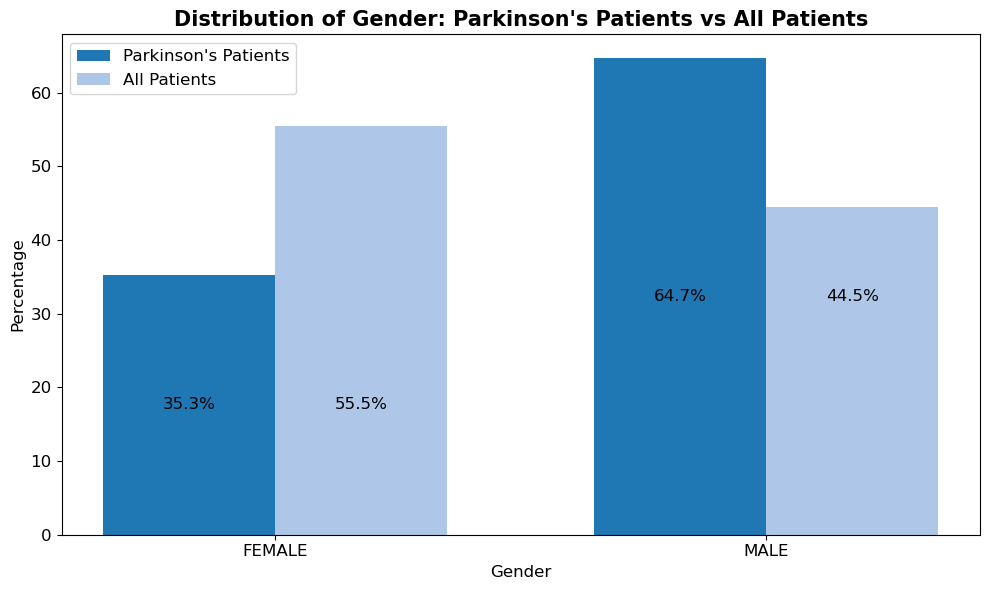

In [151]:
# Plotting the distribution of gender for PD patients vs. all patients
gender_counts = demographics['gender_source_value'].value_counts(normalize=True) * 100
gender_counts_all = demographics_all['gender_source_value'].value_counts(normalize=True)[:2] * 100 # Leaves out 'UNKNOWN' only 1 patient

# Combine percentages into a single DataFrame
combined_percentages = pd.DataFrame({
    "Parkinson's Patients": gender_counts,
    "All Patients": gender_counts_all
}).fillna(0)  # Fill NaN values with 0 in case some genders are missing in either group

# Plotting the percentage distribution of gender for both groups side by side
fig, ax = plt.subplots(figsize=(10, 6))

# Color map for the bar chart
colors = plt.cm.tab20.colors

# Calculate the width for each bar group
bar_width = 0.35

# Create the x positions for the bars
x = range(len(combined_percentages.index))

# Plot bars for Parkinson's patients
parkinsons_bars = ax.bar(x, combined_percentages["Parkinson's Patients"], width=bar_width, label="Parkinson's Patients", color=colors[0])

# Plot bars for all patients (shifted by bar_width)
all_patients_bars = ax.bar([i + bar_width for i in x], combined_percentages["All Patients"], width=bar_width, label="All Patients", color=colors[1])

# Set plot title and labels
ax.set_title("Distribution of Gender: Parkinson's Patients vs All Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Gender', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.legend(fontsize=12)

# Set the x-axis ticks to be at the center of the bars
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(combined_percentages.index, fontsize=12)

# Add the percentage values inside each bar
for bar1, bar2 in zip(parkinsons_bars, all_patients_bars):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width() / 2, height1 / 2, f"{height1:.1f}%", ha='center', va='center', fontsize=12)
    ax.text(bar2.get_x() + bar2.get_width() / 2, height1 / 2, f"{height2:.1f}%", ha='center', va='center', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [152]:
demographics['gender_source_value'].value_counts(normalize=False) 

MALE      185
FEMALE    101
Name: gender_source_value, dtype: int64

In [153]:
demographics_all['gender_source_value'].value_counts(normalize=False) 

FEMALE     144929
MALE       116224
UNKNOWN         1
Name: gender_source_value, dtype: int64

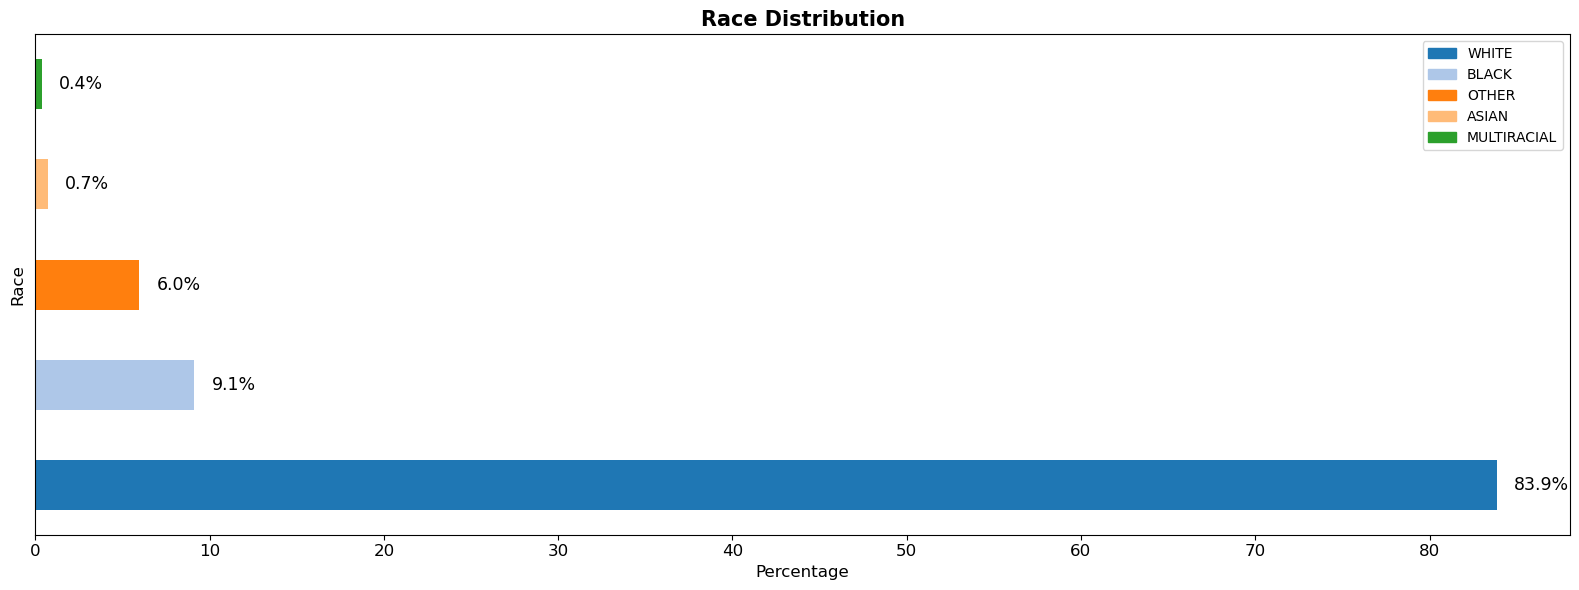

In [154]:
# Sample data (replace this with your actual data from the DataFrame)
race_counts = demographics['race_source_value'].value_counts(normalize=True) * 100

# Create a DataFrame from the data
race_df = pd.DataFrame({'Percentage': race_counts})

# Sort the DataFrame by percentage in descending order
race_df = race_df.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = race_df['Percentage'].plot(kind='barh', figsize=(16, 6), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title('Race Distribution', fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Race', fontsize=12)

# Add labels to the right of each bar
for i, v in enumerate(race_df['Percentage']):
    plt.text(v + 1, i, f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels
plt.yticks([])
plt.xticks(fontsize=12)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, race_counts.index)]

# Show the custom legend
plt.legend(handles=legend_patches, loc='best')

plt.tight_layout()
plt.show()

In [155]:
demographics['ethnicity_source_value'].value_counts()

NOT HISPANIC    272
HISPANIC         14
Name: ethnicity_source_value, dtype: int64

In [156]:
race_counts

WHITE          83.859649
BLACK           9.122807
OTHER           5.964912
ASIAN           0.701754
MULTIRACIAL     0.350877
Name: race_source_value, dtype: float64

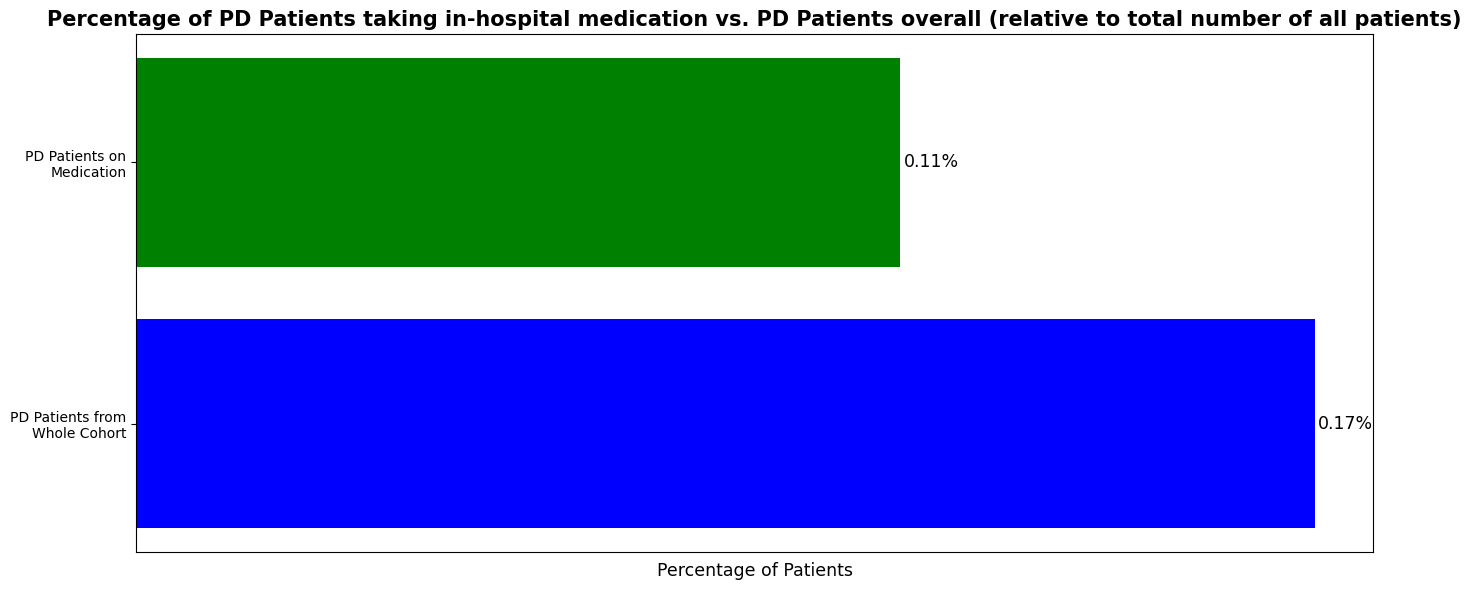

In [157]:
# Calculate the total number of patients in each dataset
total_patients_df = len(df['person_id'].unique())
total_patients_df_pd = len(df_pd['person_id'].unique())
total_patients_demographics_all = len(demographics_all['person_id'].unique())

# Calculate the percentage of PD patients from the whole cohort and PD patients on medication
percentage_pd_patients_df = (total_patients_df / total_patients_demographics_all) * 100
percentage_pd_patients = (total_patients_df_pd / total_patients_demographics_all) * 100

# Create the data for the horizontal bar plot
categories = ['PD Patients from\nWhole Cohort', 'PD Patients on\nMedication']
values = [percentage_pd_patients_df, percentage_pd_patients]

# Set the figure size for the horizontal bar plot
plt.figure(figsize=(14, 6))

# Plot the horizontal bar plot
plt.barh(categories, values, color=['blue', 'green'])
plt.xlabel('Percentage of Patients', fontsize=12.5)
plt.title('Percentage of PD Patients taking in-hospital medication vs. PD Patients overall (relative to total number of all patients)', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks([])

# Display the percentage values inside the bars
for i, v in enumerate(values):
    plt.text(v + 0.0005, i, f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Display the plot
plt.tight_layout()
plt.show()

In [158]:
percentage_pd_patients_df

0.1688658799022799

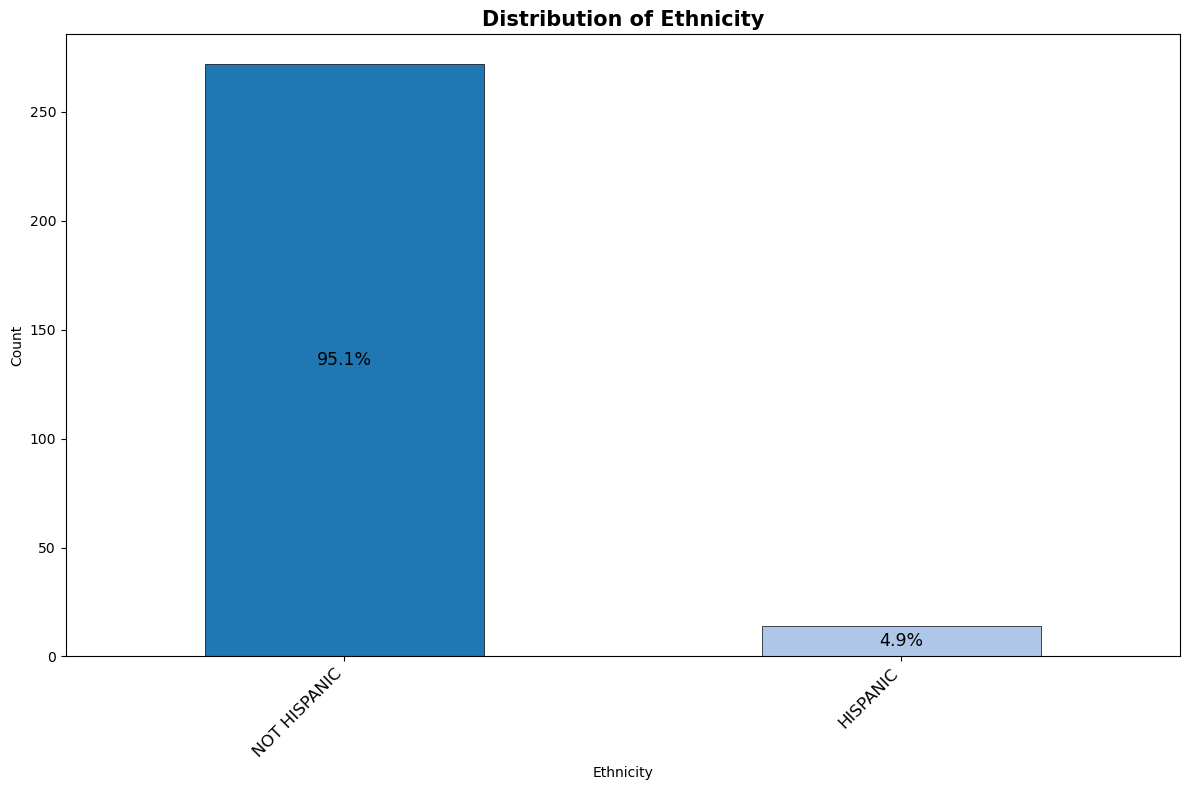

In [159]:
# Plotting value counts of race with percentages
ethnicity = demographics['ethnicity_source_value'].value_counts()
plt.figure(figsize=(12, 8))  # Adjust the values as per your desired size
labels = ethnicity.index
colors = plt.cm.tab20(np.arange(len(labels))) 
ax = ethnicity.plot(kind='bar', color=colors, edgecolor='black', linewidth=0.5)

# Calculate the percentages
total_count = ethnicity.sum()
percentages = [(count / total_count) * 100 for count in ethnicity]

# Display the percentages inside the bars
ax.bar_label(ax.containers[0], labels=[f"{percentage:.1f}%" for percentage in percentages], label_type='center', fontsize=12.5)

plt.title('Distribution of Ethnicity', fontsize=15, fontweight='bold')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

Actual actual way to deal with this lol

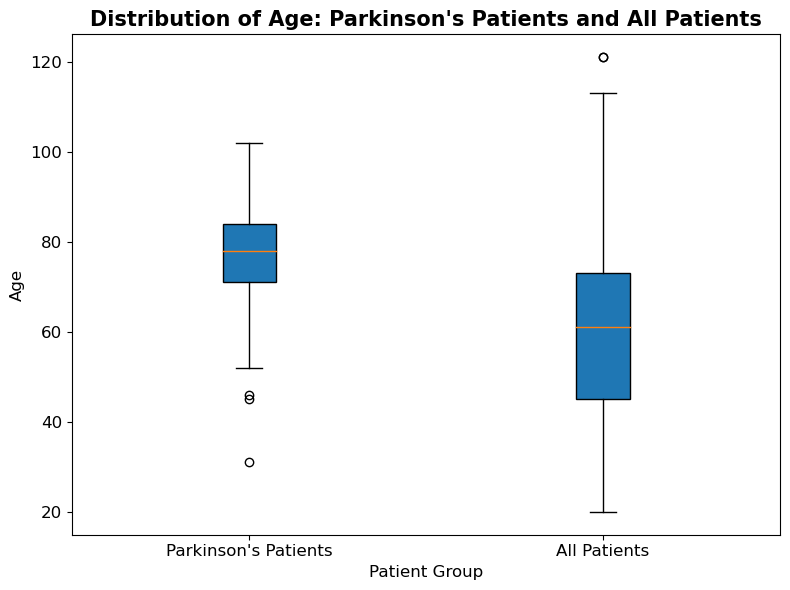

In [160]:
# Plotting the distribution of age for both groups using a box plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the box plot
ax.boxplot([demographics['age'], demographics_all['age']], labels=["Parkinson's Patients", "All Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Parkinson's Patients and All Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

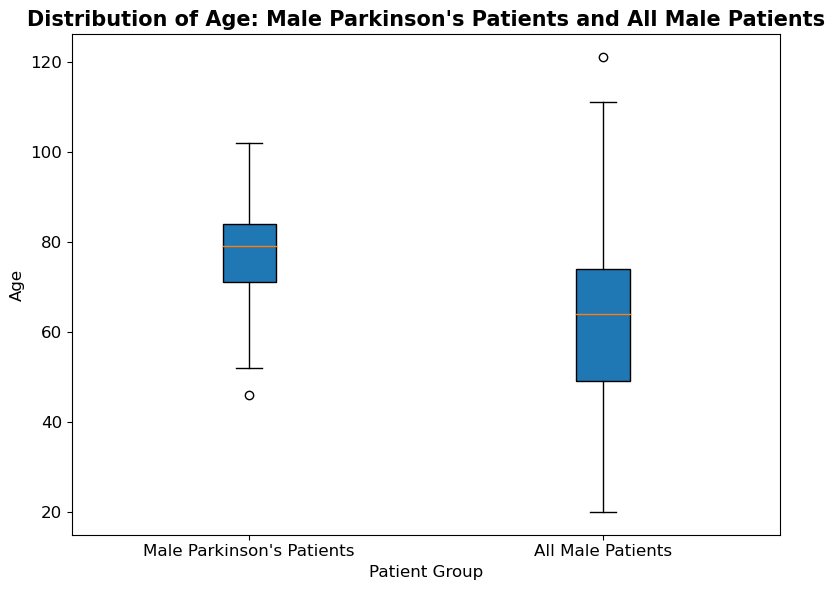

In [161]:
male_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'MALE']['age']
male_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'MALE']['age']# Plotting the distribution of age for both groups using a box plot

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, male_pd_patients_by_age_all], labels=["Male Parkinson's Patients", "All Male Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male Parkinson's Patients and All Male Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

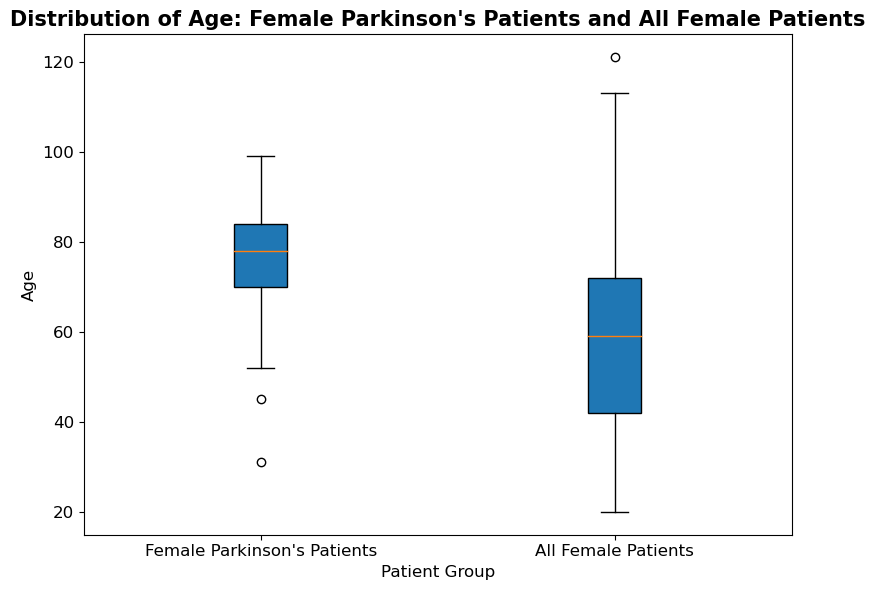

In [162]:
female_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'FEMALE']['age']
female_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'FEMALE']['age']

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([female_pd_patients_by_age, female_pd_patients_by_age_all], labels=["Female Parkinson's Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Female Parkinson's Patients and All Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

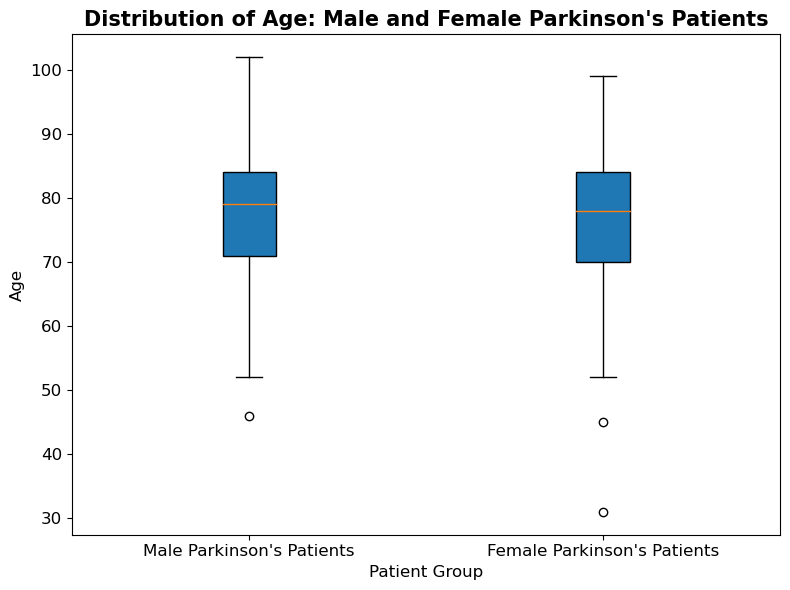

In [163]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, female_pd_patients_by_age], labels=["Male Parkinson's Patients", "Female Parkinson's Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Parkinson's Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

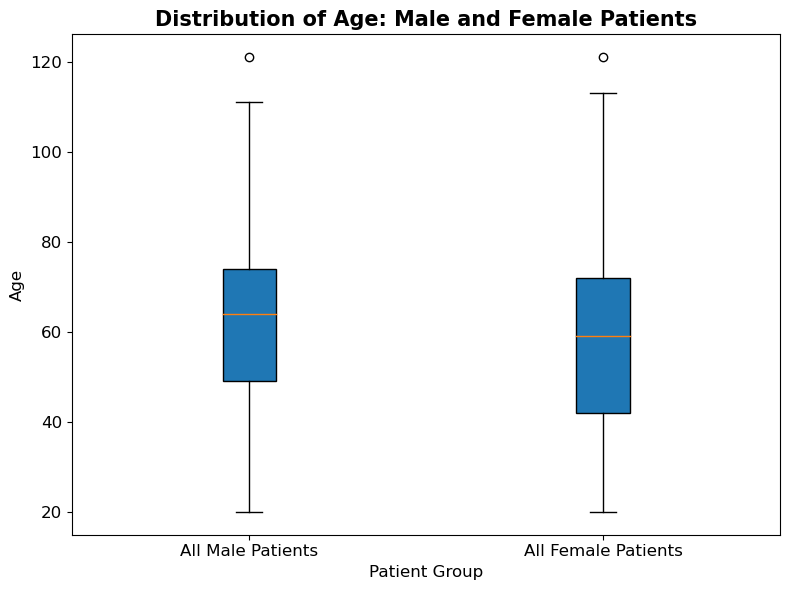

In [164]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age_all, female_pd_patients_by_age_all], labels=["All Male Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [165]:
pd_data.value_counts(normalize=True)

generic_name                           brand_name  dosage         
carbidopa-levodopa                     sinemet     25-100 mg          0.461783
                                       sinemet cr  25-100 mg          0.065150
benztropine                            cogentin    1 mg               0.064713
amantadine                             symmetrel   100 mg             0.059850
carbidopa-levodopa                     sinemet     25-250 mg          0.050000
pramipexole                            mirapex     0.25 mg            0.044701
benztropine                            cogentin    0.5 mg             0.035287
carbidopa-levodopa                     sinemet     10-100 mg          0.034040
                                                   12.5-50 mg         0.030985
                                       sinemet cr  50-200 mg          0.030050
benztropine                            cogentin    2 mg               0.014651
entacapone                             comtan      200 mg       

In [166]:
pd_data['brand_name'].value_counts(normalize=True)

sinemet       0.584601
cogentin      0.120324
sinemet cr    0.095200
symmetrel     0.074751
mirapex       0.069327
comtan        0.014963
artane        0.009726
azilect       0.007107
eldepryl      0.004302
duopa         0.003491
stalevo       0.003117
parlodel      0.003055
neupro        0.002681
gocovri       0.001995
parcopa       0.001372
rytary        0.001372
requip        0.000873
lodosyn       0.000686
tasmar        0.000623
dostinex      0.000249
apokyn        0.000187
Name: brand_name, dtype: float64

## Distribution of drugs

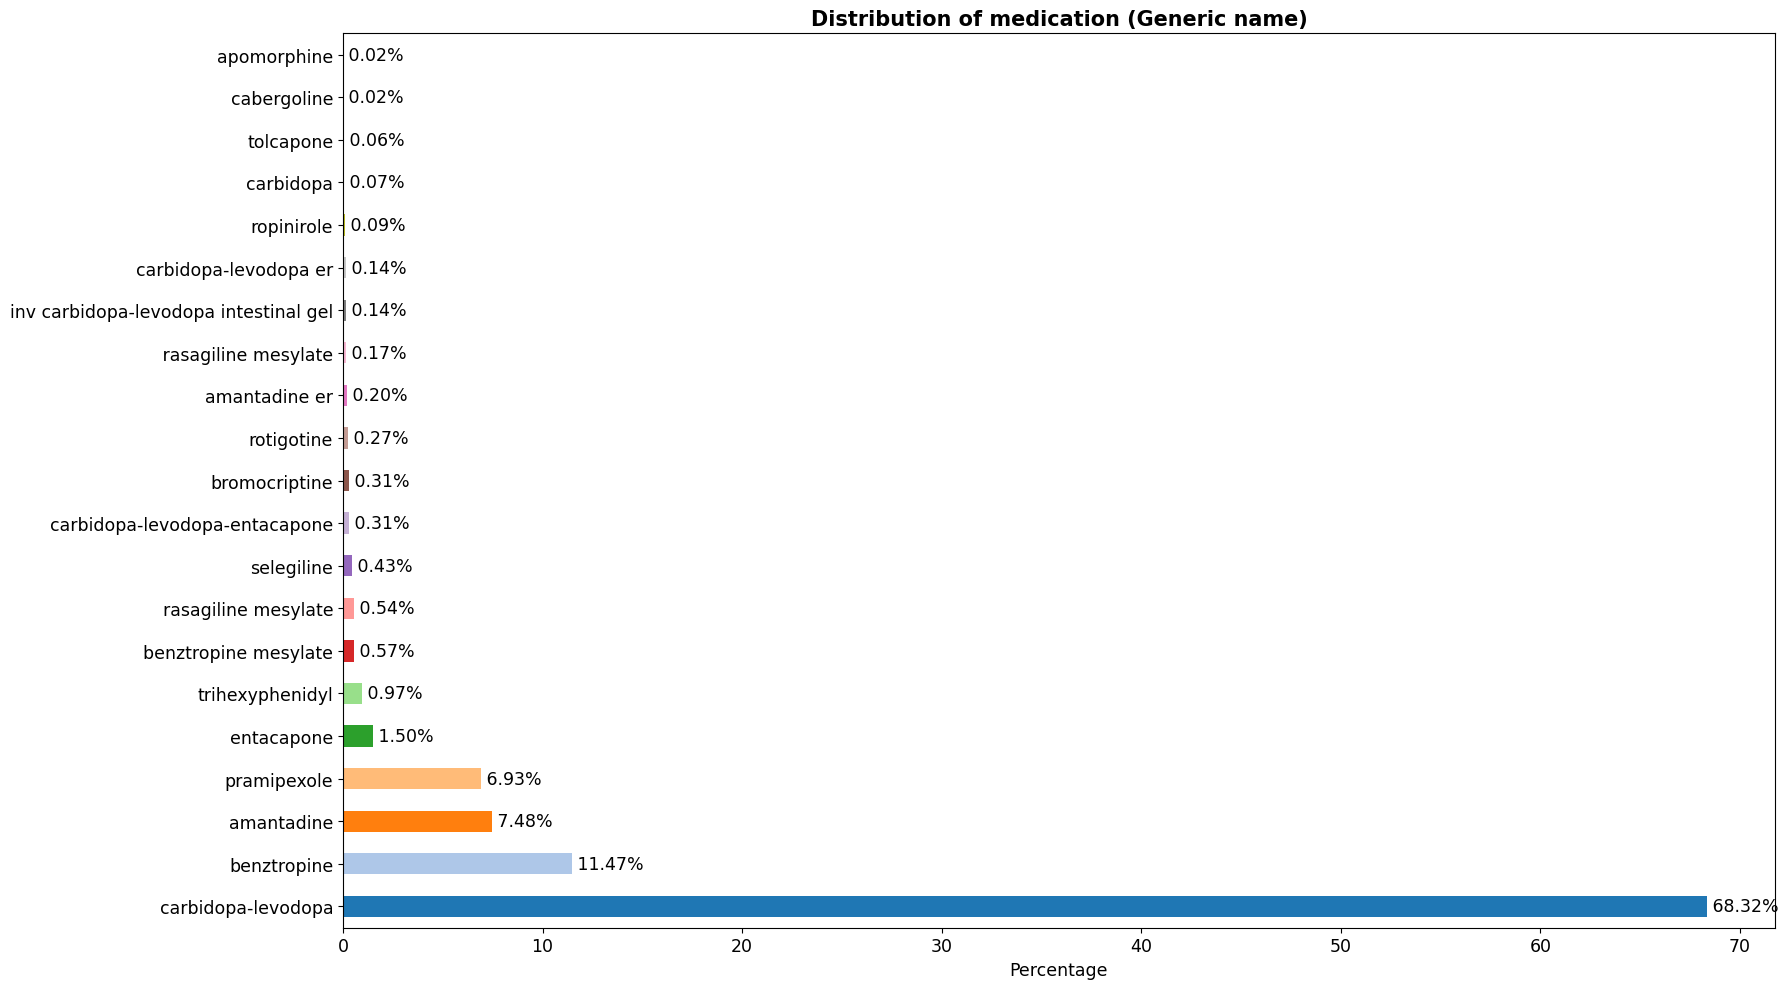

In [167]:
drug_distribution_count = df_pd['generic_name'].value_counts(normalize=True) * 100
drug_distribution = pd.DataFrame({'Percentage': drug_distribution_count})

# Sort the DataFrame by percentage in descending order
drug_distribution = drug_distribution.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_distribution['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Distribution of medication (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_distribution['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_distribution)), drug_distribution.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_distribution.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


In [168]:
len(pd_data) == len(df_pd)

True

In [169]:
df_pd.iloc[5187]

person_id                                                            250766
age                                                                      85
gender_source_value                                                  FEMALE
race_source_value                                                     WHITE
ethnicity_source_value                                         NOT HISPANIC
drug_source_value         {"med_display_name": "**carbidopa-levodopa 4.6...
drug_info                                                               NaN
generic_name                                             carbidopa-levodopa
brand_name                                                            duopa
dosage                                                        4.63-20 mg/ml
quantity                                                              100.0
sig                                                                   DAILY
route_source_value                                               PER J TUBE
dose_source_

In [170]:
pd_data.iloc[5187]

generic_name    carbidopa-levodopa
brand_name                   duopa
dosage               4.63-20 mg/ml
Name: 5187, dtype: object

In [171]:
len(pd_data[pd_data['brand_name'] == 'duopa']) == len(df_pd[df_pd['brand_name'] == 'duopa'])

True

<AxesSubplot: >

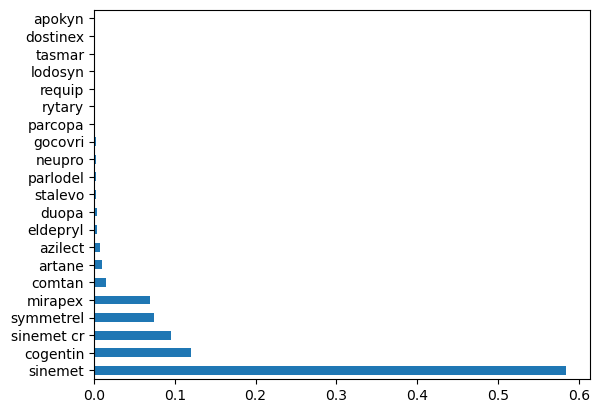

In [172]:
# vlalue_counts: Number of times each unique elements appears
medication_data = pd_data['brand_name'].value_counts(normalize=True)
medication_data.plot(kind='barh')

In [173]:
df_pd.groupby('brand_name')['person_id'].nunique()

brand_name
apokyn          1
artane          7
azilect        12
cogentin       22
comtan          8
dostinex        1
duopa           2
eldepryl        5
gocovri         1
lodosyn         4
mirapex        29
neupro          8
parcopa         2
parlodel        2
requip          3
rytary          2
sinemet       244
sinemet cr     82
stalevo         4
symmetrel      33
tasmar          1
Name: person_id, dtype: int64

In [174]:
df_pd['brand_name'].nunique()

21

In [175]:
df_pd.columns

Index(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value', 'drug_source_value', 'drug_info',
       'generic_name', 'brand_name', 'dosage', 'quantity', 'sig',
       'route_source_value', 'dose_source_value', 'dose_unit_source_value',
       'note_text'],
      dtype='object')

In [176]:
# Drug usage per patient
drug_percentage = df_pd.groupby('race_source_value')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_percentage.sort_values(ascending=False)
# drug_percentage

race_source_value
WHITE          0.835664
BLACK          0.090909
OTHER          0.059441
ASIAN          0.006993
MULTIRACIAL    0.003497
Name: person_id, dtype: float64

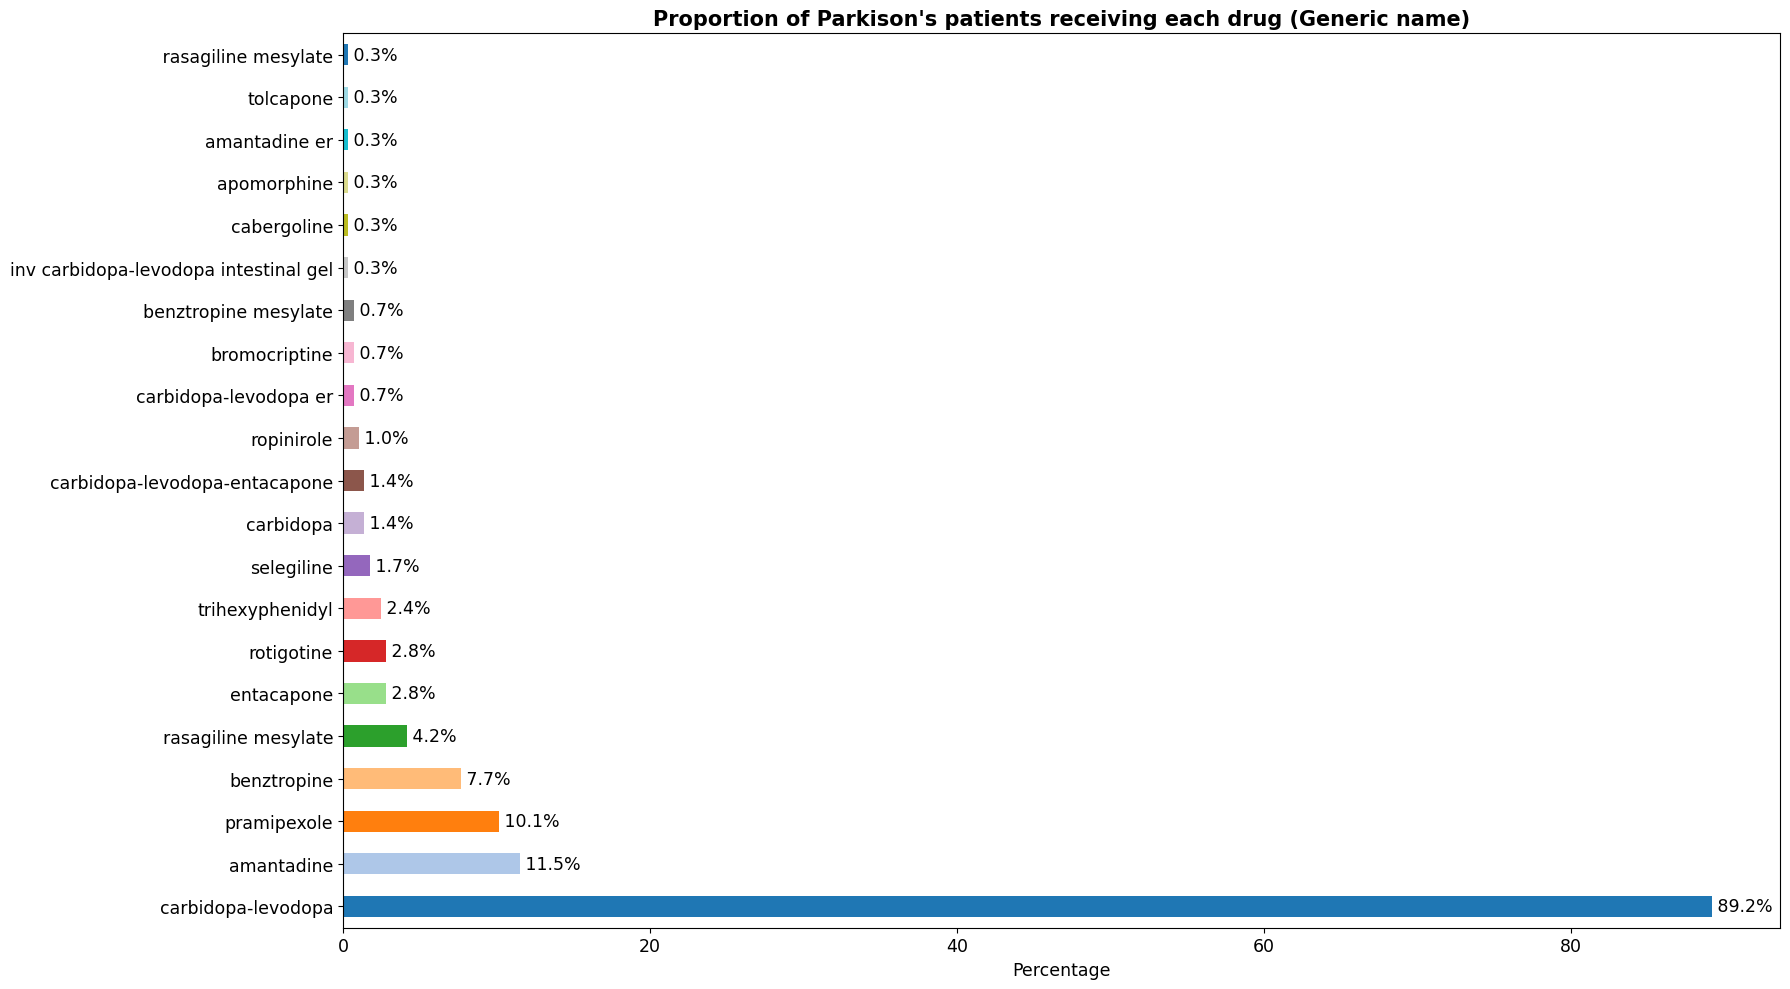

In [177]:
drug_percentage = df_pd.groupby('generic_name')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_popularity_count = drug_percentage * 100
drug_popularity = pd.DataFrame({'Percentage': drug_popularity_count})

# Sort the DataFrame by percentage in descending order
drug_popularity = drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Parkison's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_popularity)), drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


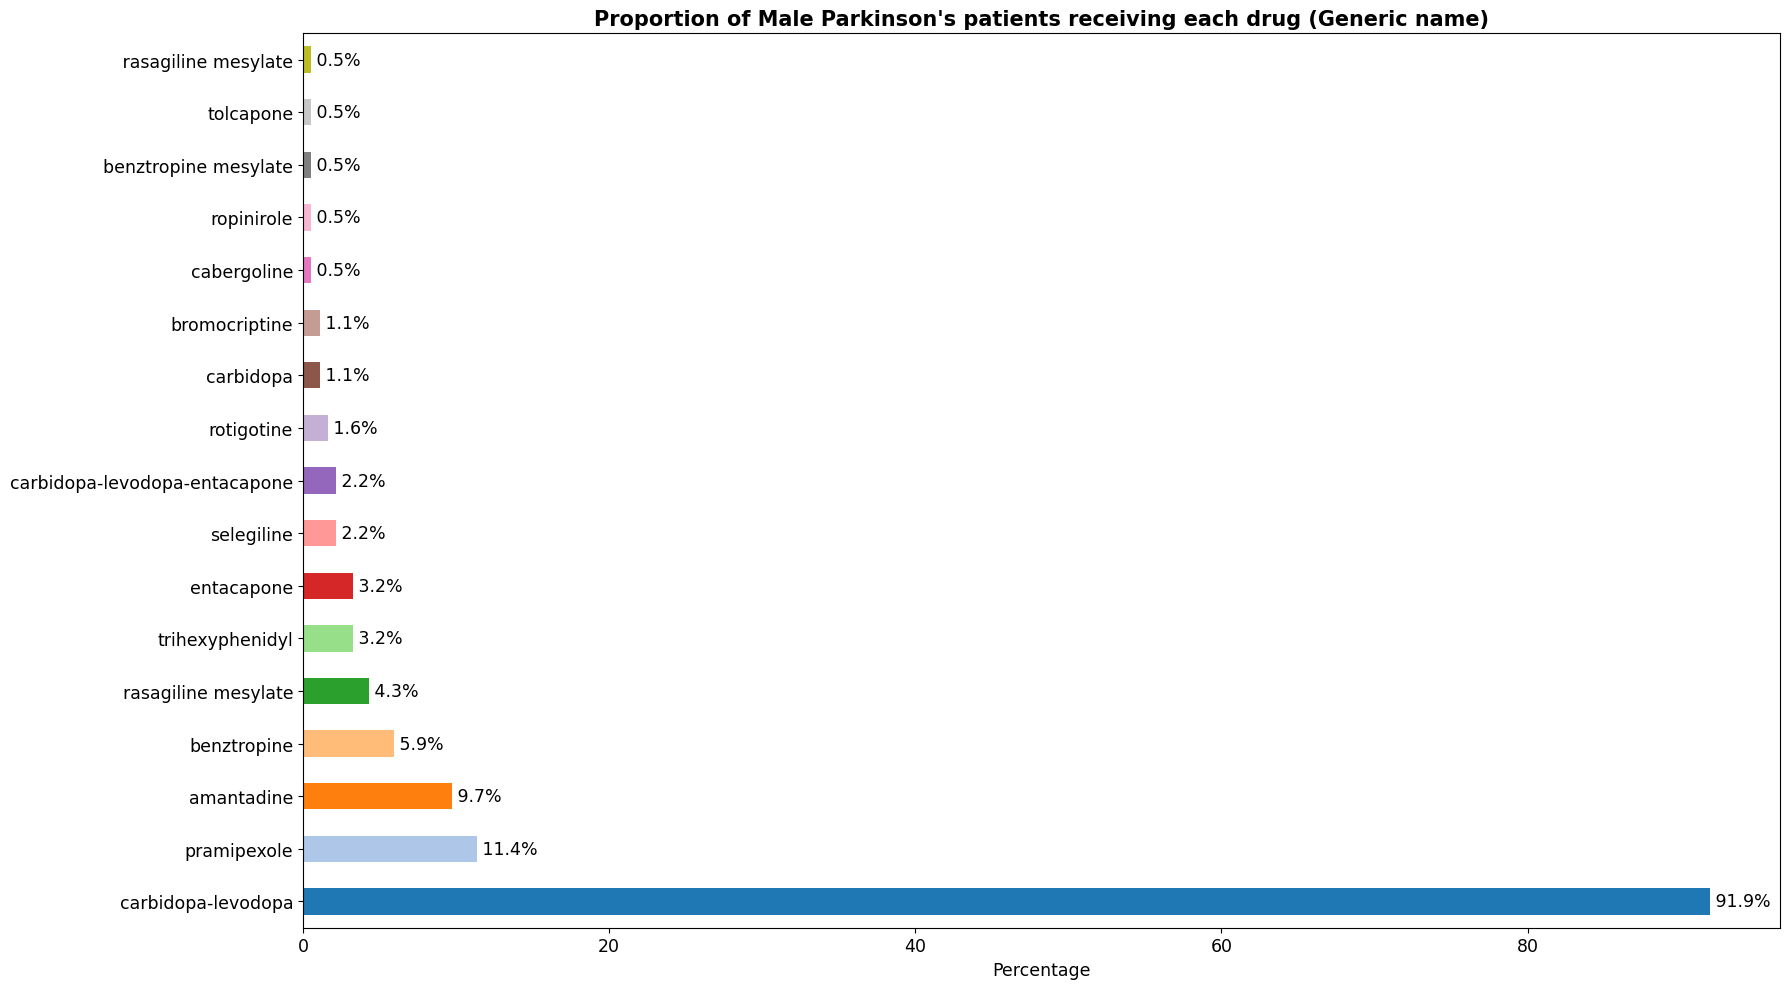

In [178]:
# Assuming df_pd is a DataFrame containing drug data and 'gender_source_value' is a column representing gender

# Filter the DataFrame for 'gender_source_value' == 'MALE'
male_pd = df_pd[df_pd['gender_source_value'] == 'MALE']

# Calculate the drug percentage for males
male_drug_percentage = male_pd.groupby('generic_name')['person_id'].nunique() / male_pd['person_id'].nunique()

# Calculate the percentage popularity of each drug for males
male_drug_popularity_count = male_drug_percentage * 100
male_drug_popularity = pd.DataFrame({'Percentage': male_drug_popularity_count})

# Sort the DataFrame by percentage in descending order
male_drug_popularity = male_drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = male_drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Male Parkinson's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(male_drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(male_drug_popularity)), male_drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, male_drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


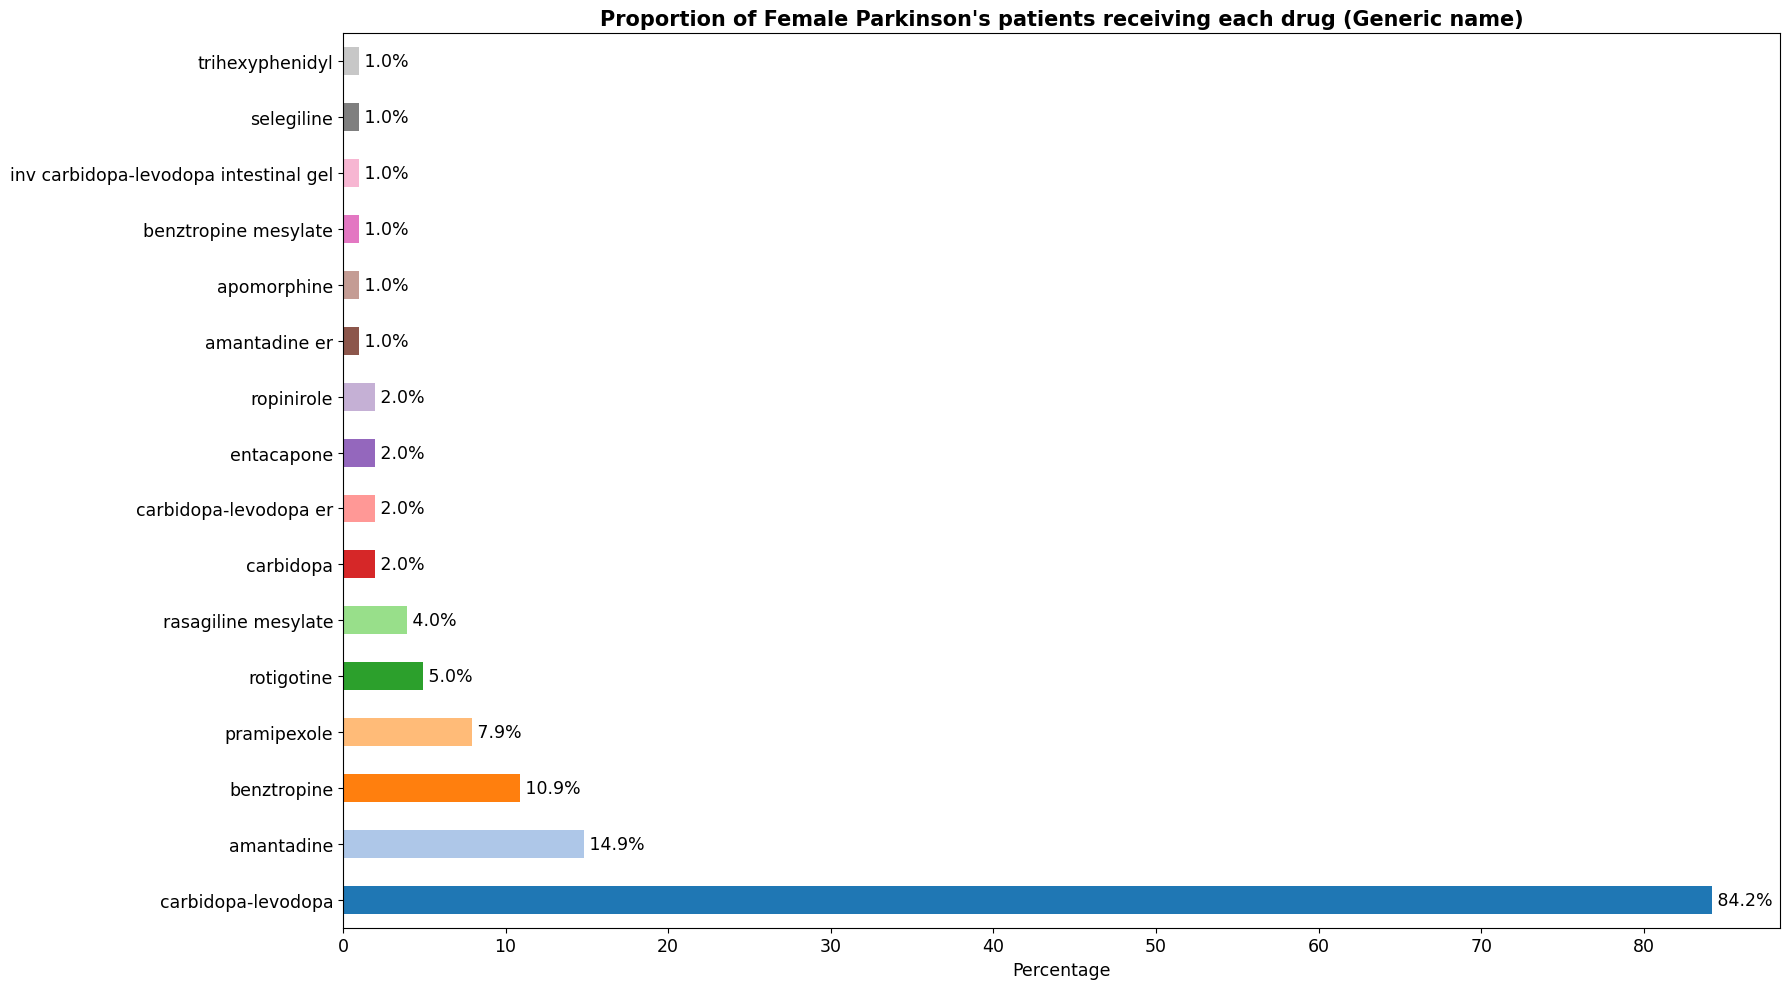

In [179]:
# Assuming df_pd is a DataFrame containing drug data and 'gender_source_value' is a column representing gender

# Filter the DataFrame for 'gender_source_value' == 'MALE'
female_pd = df_pd[df_pd['gender_source_value'] == 'FEMALE']

# Calculate the drug percentage for males
female_drug_percentage = female_pd.groupby('generic_name')['person_id'].nunique() / female_pd['person_id'].nunique()

# Calculate the percentage popularity of each drug for males
female_drug_popularity_count = female_drug_percentage * 100
female_drug_popularity = pd.DataFrame({'Percentage': female_drug_popularity_count})

# Sort the DataFrame by percentage in descending order
female_drug_popularity = female_drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = female_drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Female Parkinson's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(female_drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(female_drug_popularity)), female_drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, female_drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()

In [180]:
female_drug_popularity['Percentage']

generic_name
carbidopa-levodopa                       84.158416
amantadine                               14.851485
benztropine                              10.891089
pramipexole                               7.920792
rotigotine                                4.950495
rasagiline mesylate                       3.960396
carbidopa                                 1.980198
carbidopa-levodopa er                     1.980198
entacapone                                1.980198
ropinirole                                1.980198
amantadine er                             0.990099
apomorphine                               0.990099
benztropine mesylate                      0.990099
inv carbidopa-levodopa intestinal gel     0.990099
selegiline                                0.990099
trihexyphenidyl                           0.990099
Name: Percentage, dtype: float64

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


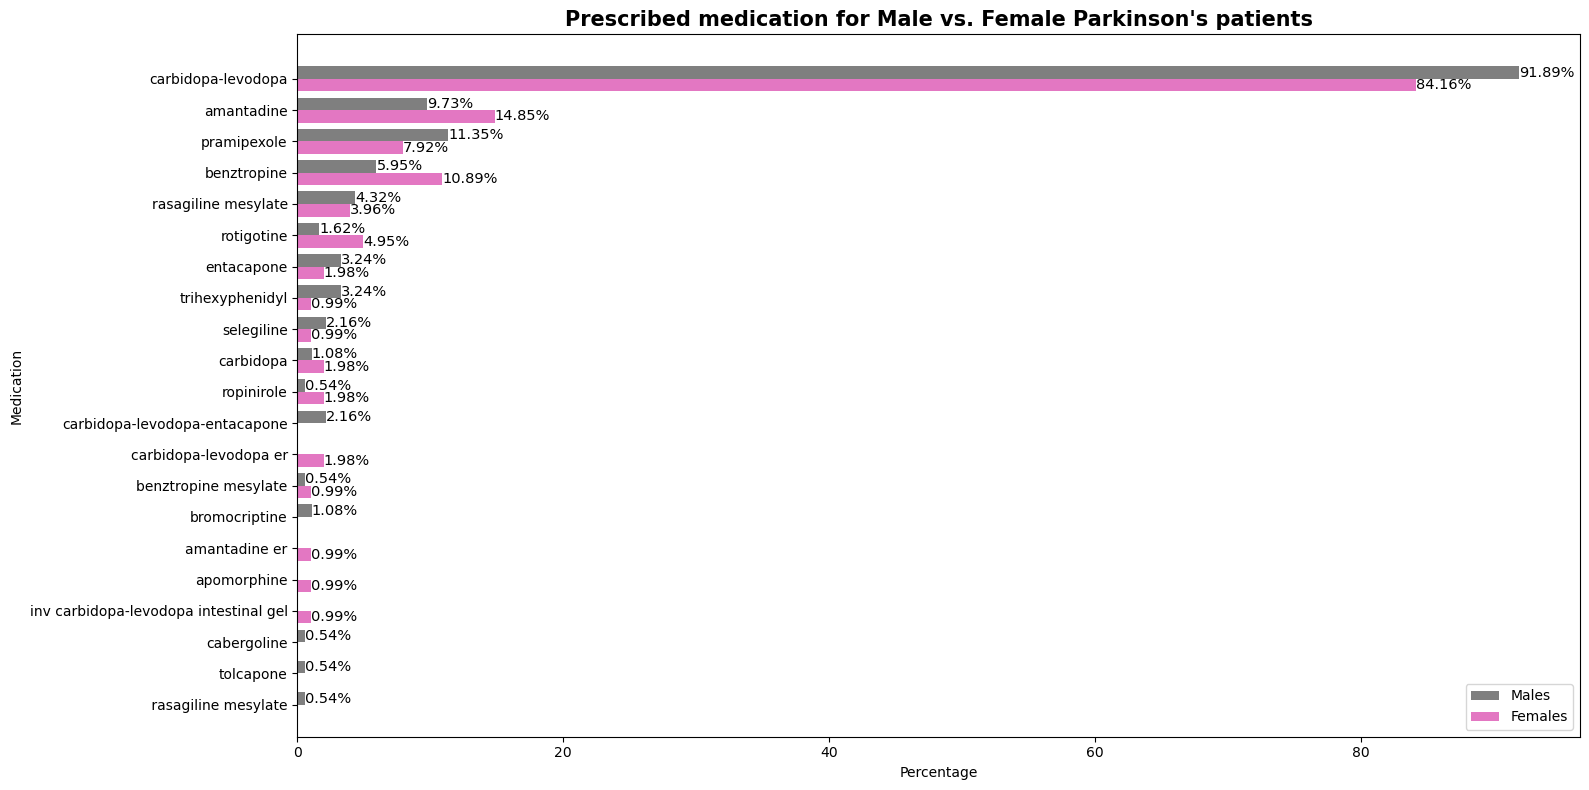

In [181]:
# Assuming you already have these variables as pandas Series
# male_drug_popularity and female_drug_popularity with 'Percentage' as the data and medication names as the index.

# Combine both male and female data for sorting
combined_data = pd.concat([male_drug_popularity, female_drug_popularity], axis=1)
combined_data.columns = ['Males', 'Females']

# Sort the medications based on the sum of percentages (sorting from higher to lower)
sorted_combined = combined_data.sum(axis=1).sort_values(ascending=False)

# Plotting the data as a horizontal bar plot
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed

# Increase the width of the bars and adjust figure size for better spacing
width = 0.4

# Bar plot for males
ind_male = range(len(sorted_combined))
bars_male = plt.barh(ind_male, combined_data.loc[sorted_combined.index, 'Males'], height=width, label='Males', color='tab:gray')

# Bar plot for females
ind_female = [i + width for i in ind_male]
bars_female = plt.barh(ind_female, combined_data.loc[sorted_combined.index, 'Females'], height=width, label='Females', color='tab:pink')

# Adding percentages to the side of the bars
for i, val in enumerate(combined_data.loc[sorted_combined.index, 'Males']):
    plt.text(val, i, f'{val:.2f}%', va='center', fontsize=10.5, color='black')

for i, val in enumerate(combined_data.loc[sorted_combined.index, 'Females']):
    plt.text(val, i + width, f'{val:.2f}%', va='center', fontsize=10.5, color='black')

# Adding labels, titles, and customizing the plot
plt.xlabel('Percentage')
plt.ylabel('Medication')
plt.title('Prescribed medication for Male vs. Female Parkinson\'s patients', fontsize=15, fontweight='bold')
plt.yticks([i + width / 2 for i in ind_male], sorted_combined.index, fontsize=10)
plt.gca().invert_yaxis()
plt.legend(loc='lower right')  # Move the legend to upper right for better spacing
plt.tight_layout()
plt.show()


In [182]:
df_pd['generic_name'].value_counts(normalize=True) * 100

carbidopa-levodopa                       68.322943
benztropine                              11.465087
amantadine                                7.475062
pramipexole                               6.932668
entacapone                                1.496259
trihexyphenidyl                           0.972569
benztropine mesylate                      0.567332
rasagiline mesylate                       0.536160
selegiline                                0.430175
carbidopa-levodopa-entacapone             0.311721
bromocriptine                             0.305486
rotigotine                                0.268080
amantadine er                             0.199501
 rasagiline mesylate                      0.174564
inv carbidopa-levodopa intestinal gel     0.143392
carbidopa-levodopa er                     0.137157
ropinirole                                0.087282
carbidopa                                 0.068579
tolcapone                                 0.062344
cabergoline                    

In [183]:
drug_percentage

generic_name
 rasagiline mesylate                     0.003497
amantadine                               0.115385
amantadine er                            0.003497
apomorphine                              0.003497
benztropine                              0.076923
benztropine mesylate                     0.006993
bromocriptine                            0.006993
cabergoline                              0.003497
carbidopa                                0.013986
carbidopa-levodopa                       0.891608
carbidopa-levodopa er                    0.006993
carbidopa-levodopa-entacapone            0.013986
entacapone                               0.027972
inv carbidopa-levodopa intestinal gel    0.003497
pramipexole                              0.101399
rasagiline mesylate                      0.041958
ropinirole                               0.010490
rotigotine                               0.027972
selegiline                               0.017483
tolcapone                            

## Calculating LED (Levodopa Dose Equivalent) for Parkinson's patients

In [184]:
# sig stablished how the medication should be taken by the patient
formatted_series = df_pd['dose_source_value'].unique()
format_func = np.vectorize(lambda x: '{:.4}'.format(x))
bla = np.sort(format_func(formatted_series))
bla

array(['0.0', '0.125', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5',
       '100.0', '137.0', '2.0', '2.5', '20.0', '200.0', '25.0', '3.0',
       '32.0', '4.0', '40.0', '5.0', '50.0', '8.0', 'nan'], dtype='<U5')

In [185]:
drug_exposure

,person_id,drug_exposure_start_datetime,drug_source_value,dose_source_value,dose_unit_source_value,route_source_value,visit_occurrence_id,visit_detail_id
0,261006,2021-04-11 10:53:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
1,261006,2021-04-11 14:58:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
2,261006,2021-04-11 17:32:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
3,261006,2021-04-11 21:31:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
4,261006,2021-04-12 02:52:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
...,...,...,...,...,...,...,...,...
26941,175605,2017-09-20 13:51:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,tablet,ORAL,27807633,6375345.0
26942,175605,2017-09-20 21:09:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,tablet,ORAL,27807633,6375345.0
26943,175605,2017-09-21 08:50:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,tablet,ORAL,27807633,6375345.0
26944,175605,2017-09-19 10:08:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",0.0,tablet,ORAL,27807633,6375345.0


In [186]:
rasagiline_index = pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '1mg'].index
pd_data_drug_exposure.loc[rasagiline_index, 'dosage'] = '1 mg'
pd_data_drug_exposure.iloc[rasagiline_index]['dosage']

10477    1 mg
10478    1 mg
Name: dosage, dtype: object

In [187]:
entacapone_index = pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '200mg'].index
pd_data_drug_exposure.loc[entacapone_index, 'dosage'] = '200 mg'
pd_data_drug_exposure.iloc[entacapone_index]['dosage']

13141    200 mg
13142    200 mg
13143    200 mg
13144    200 mg
13145    200 mg
13146    200 mg
13147    200 mg
13148    200 mg
13149    200 mg
13150    200 mg
13151    200 mg
13152    200 mg
13153    200 mg
13154    200 mg
13155    200 mg
13156    200 mg
13157    200 mg
13158    200 mg
13159    200 mg
13160    200 mg
13161    200 mg
13162    200 mg
13163    200 mg
13164    200 mg
13165    200 mg
13166    200 mg
13167    200 mg
13168    200 mg
13169    200 mg
13170    200 mg
Name: dosage, dtype: object

In [188]:
pd_data_drug_exposure['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [189]:
pd_data_drug_exposure['dosage'].unique()[0].split('-')[1].split()[0]

'100'

In [190]:
led_dose = []
for index, item in enumerate(pd_data_drug_exposure['dosage']):
    if '-' in item:
        dosage = item.split('-')[1].split()[0]
    else:
        dosage = item.split()[0]
    led_dose.append(dosage)

In [191]:
len(pd_data_drug_exposure)

26946

In [192]:
set(sorted(led_dose))

{'0.125',
 '0.25',
 '0.5',
 '0.75',
 '1',
 '1.25',
 '1.5',
 '100',
 '12',
 '125',
 '137',
 '145',
 '150',
 '195',
 '2',
 '2.25',
 '2.5',
 '20',
 '200',
 '25',
 '250',
 '3',
 '4',
 '5',
 '50',
 '6',
 '75',
 '8',
 '95'}

In [193]:
for index, item in enumerate(pd_data_drug_exposure['generic_name']):
    if 'levodopa-carbidopa' in item:
        print(item)

In [194]:
pd_data_drug_exposure['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'pramipexole',
       'ropinirole', 'benztropine mesylate', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'trihexyphenidyl',
       'carbidopa', 'carbidopa-levodopa er', 'rasagiline mesylate',
       'rotigotine', 'apomorphine', 'amantadine er',
       ' rasagiline mesylate', 'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump', 'cabergoline',
       'pramipexole er', 'rasagiline', 'bromocriptine', 'tolcapone'],
      dtype=object)

In [195]:
pd_data_drug_exposure

,generic_name,brand_name,dosage
0,carbidopa-levodopa,sinemet,25-100 mg
1,carbidopa-levodopa,sinemet,25-100 mg
2,carbidopa-levodopa,sinemet,25-100 mg
3,carbidopa-levodopa,sinemet,25-100 mg
4,carbidopa-levodopa,sinemet,25-100 mg
...,...,...,...
26941,carbidopa-levodopa,sinemet,25-100 mg
26942,carbidopa-levodopa,sinemet,25-100 mg
26943,carbidopa-levodopa,sinemet,25-100 mg
26944,carbidopa-levodopa,sinemet,25-100 mg


In [196]:
drug_exposure

,person_id,drug_exposure_start_datetime,drug_source_value,dose_source_value,dose_unit_source_value,route_source_value,visit_occurrence_id,visit_detail_id
0,261006,2021-04-11 10:53:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
1,261006,2021-04-11 14:58:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
2,261006,2021-04-11 17:32:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
3,261006,2021-04-11 21:31:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
4,261006,2021-04-12 02:52:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
...,...,...,...,...,...,...,...,...
26941,175605,2017-09-20 13:51:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,tablet,ORAL,27807633,6375345.0
26942,175605,2017-09-20 21:09:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,tablet,ORAL,27807633,6375345.0
26943,175605,2017-09-21 08:50:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,tablet,ORAL,27807633,6375345.0
26944,175605,2017-09-19 10:08:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",0.0,tablet,ORAL,27807633,6375345.0


In [197]:
led_df = pd.concat([drug_exposure.iloc[:, 0:3], pd_data_drug_exposure, drug_exposure.iloc[:, 3:]], axis=1)

In [198]:
led_df.insert(loc=6, column="led_dose", value=led_dose)
led_df.insert(loc=3, column="drug_info", value=drug_info_drug_source_value)
# Properly handling the led_dose and drug_exposure_start_datetime colums
led_df['led_dose'] = pd.to_numeric(led_df['led_dose'], errors='coerce') # Coverting this column to a float type and handling uncommon values
led_df['drug_exposure_start_datetime'] = pd.to_datetime(led_df['drug_exposure_start_datetime'])

In [199]:
len(drug_exposure)

26946

In [200]:
len(pd_data_drug_exposure)

26946

In [201]:
drug_exposure

,person_id,drug_exposure_start_datetime,drug_source_value,dose_source_value,dose_unit_source_value,route_source_value,visit_occurrence_id,visit_detail_id
0,261006,2021-04-11 10:53:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
1,261006,2021-04-11 14:58:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
2,261006,2021-04-11 17:32:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
3,261006,2021-04-11 21:31:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
4,261006,2021-04-12 02:52:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,tablet,ORAL,40422623,9880783.0
...,...,...,...,...,...,...,...,...
26941,175605,2017-09-20 13:51:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,tablet,ORAL,27807633,6375345.0
26942,175605,2017-09-20 21:09:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,tablet,ORAL,27807633,6375345.0
26943,175605,2017-09-21 08:50:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,tablet,ORAL,27807633,6375345.0
26944,175605,2017-09-19 10:08:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",0.0,tablet,ORAL,27807633,6375345.0


In [202]:
led_df

,person_id,drug_exposure_start_datetime,drug_source_value,drug_info,generic_name,brand_name,dosage,led_dose,dose_source_value,dose_unit_source_value,route_source_value,visit_occurrence_id,visit_detail_id
0,261006,2021-04-11 10:53:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,2.0,tablet,ORAL,40422623,9880783.0
1,261006,2021-04-11 14:58:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,2.0,tablet,ORAL,40422623,9880783.0
2,261006,2021-04-11 17:32:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,2.0,tablet,ORAL,40422623,9880783.0
3,261006,2021-04-11 21:31:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,2.0,tablet,ORAL,40422623,9880783.0
4,261006,2021-04-12 02:52:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,2.0,tablet,ORAL,40422623,9880783.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26941,175605,2017-09-20 13:51:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,1.0,tablet,ORAL,27807633,6375345.0
26942,175605,2017-09-20 21:09:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,1.0,tablet,ORAL,27807633,6375345.0
26943,175605,2017-09-21 08:50:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,1.0,tablet,ORAL,27807633,6375345.0
26944,175605,2017-09-19 10:08:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,0.0,tablet,ORAL,27807633,6375345.0


Esta bieeeeeeeeeeeeeeeeeeen y funciona

In [203]:
dl = [json.loads(x) for x in led_df[led_df['dose_source_value'] == 0.0]['drug_source_value']]
for index, tem in enumerate(dl):
    print(index, led_df['person_id'].iloc[index], dl[index]['mar_action'], led_df['drug_source_value'].iloc[index])
len(dl)

0 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
1 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
2 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
3 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
4 261006 HELD {"med_display_name": "

953

In [204]:
type(led_df[led_df['dose_source_value'] == 0.0]['drug_source_value'])

pandas.core.series.Series

In [205]:
type(led_df.loc[led_df['dose_source_value'] == 0.0, ['drug_source_value']])

pandas.core.frame.DataFrame

In [206]:
bla = [json.loads(x) for x in led_df[led_df['dose_source_value'] == 0.0]['drug_source_value']]
for index, item in enumerate(bla):
    print(bla[index]['mar_action'])

HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD


We lose 18.9% percent of patients because their medication was held

In [207]:
print(len(dl)*100/len(df_pd))

5.94139650872818


In [208]:
led_df['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [209]:
pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '0.5 mg']

,generic_name,brand_name,dosage
88,benztropine,cogentin,0.5 mg
89,benztropine,cogentin,0.5 mg
90,benztropine,cogentin,0.5 mg
91,benztropine,cogentin,0.5 mg
92,benztropine,cogentin,0.5 mg
...,...,...,...
24965,ropinirole,requip,0.5 mg
24966,ropinirole,requip,0.5 mg
24967,ropinirole,requip,0.5 mg
24968,ropinirole,requip,0.5 mg


In [210]:
pd_data_drug_exposure['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [211]:
led_df['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [212]:
set(led_dose)

{'0.125',
 '0.25',
 '0.5',
 '0.75',
 '1',
 '1.25',
 '1.5',
 '100',
 '12',
 '125',
 '137',
 '145',
 '150',
 '195',
 '2',
 '2.25',
 '2.5',
 '20',
 '200',
 '25',
 '250',
 '3',
 '4',
 '5',
 '50',
 '6',
 '75',
 '8',
 '95'}

In [213]:
led_df['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'pramipexole',
       'ropinirole', 'benztropine mesylate', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'trihexyphenidyl',
       'carbidopa', 'carbidopa-levodopa er', 'rasagiline mesylate',
       'rotigotine', 'apomorphine', 'amantadine er',
       ' rasagiline mesylate', 'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump', 'cabergoline',
       'pramipexole er', 'rasagiline', 'bromocriptine', 'tolcapone'],
      dtype=object)

In [214]:
led_df[(led_df['brand_name'] == 'rytary') & (led_df['generic_name'] == 'carbidopa-levodopa')]

,person_id,drug_exposure_start_datetime,drug_source_value,drug_info,generic_name,brand_name,dosage,led_dose,dose_source_value,dose_unit_source_value,route_source_value,visit_occurrence_id,visit_detail_id
3633,256628,2017-01-24 01:00:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,rytary,25-100 mg,100.0,1.0,tablet,ORAL,39519189,9635043.0
3634,256628,2017-01-31 21:33:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,rytary,25-100 mg,100.0,1.0,tablet,ORAL,39519190,9635045.0


In [215]:
led_df[led_df['dose_unit_source_value'] == 'tablet']['dose_source_value']

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
26941    1.0
26942    1.0
26943    1.0
26944    0.0
26945    0.0
Name: dose_source_value, Length: 20044, dtype: float64

In [216]:
led_df[led_df['dose_unit_source_value'] == 'each']#['dose_source_value'].unique()

,person_id,drug_exposure_start_datetime,drug_source_value,drug_info,generic_name,brand_name,dosage,led_dose,dose_source_value,dose_unit_source_value,route_source_value,visit_occurrence_id,visit_detail_id
8143,245457,2013-03-15 23:27:00,"{""med_display_name"": ""Inv levodopa-carbidopa i...",Inv levodopa-carbidopa intestinal gel pump stop,inv carbidopa-levodopa intestinal gel pump,duopa,5-20 mg/ml,20.0,NaN,each,PEG-J TUBE,37041564,8941399.0
8144,245457,2013-03-16 23:39:00,"{""med_display_name"": ""Inv levodopa-carbidopa i...",Inv levodopa-carbidopa intestinal gel pump stop,inv carbidopa-levodopa intestinal gel pump,duopa,5-20 mg/ml,20.0,NaN,each,PEG-J TUBE,37041564,8941399.0
8145,245457,2013-03-17 23:15:00,"{""med_display_name"": ""Inv levodopa-carbidopa i...",Inv levodopa-carbidopa intestinal gel pump stop,inv carbidopa-levodopa intestinal gel pump,duopa,5-20 mg/ml,20.0,NaN,each,PEG-J TUBE,37041564,8941399.0
8146,245457,2013-03-18 23:00:00,"{""med_display_name"": ""Inv levodopa-carbidopa i...",Inv levodopa-carbidopa intestinal gel pump stop,inv carbidopa-levodopa intestinal gel pump,duopa,5-20 mg/ml,20.0,NaN,each,PEG-J TUBE,37041564,8941399.0
8147,245457,2013-03-19 23:26:00,"{""med_display_name"": ""Inv levodopa-carbidopa i...",Inv levodopa-carbidopa intestinal gel pump stop,inv carbidopa-levodopa intestinal gel pump,duopa,5-20 mg/ml,20.0,NaN,each,PEG-J TUBE,37041564,8941399.0
8148,245457,2013-03-21 00:00:00,"{""med_display_name"": ""Inv levodopa-carbidopa i...",Inv levodopa-carbidopa intestinal gel pump stop,inv carbidopa-levodopa intestinal gel pump,duopa,5-20 mg/ml,20.0,0.0,each,PEG-J TUBE,37041564,8941399.0
8149,245457,2013-03-21 23:14:00,"{""med_display_name"": ""Inv levodopa-carbidopa i...",Inv levodopa-carbidopa intestinal gel pump stop,inv carbidopa-levodopa intestinal gel pump,duopa,5-20 mg/ml,20.0,0.0,each,PEG-J TUBE,37041564,8941399.0


In [217]:
led_df[led_df['dose_unit_source_value'] != 'tablet'].sample(20)

,person_id,drug_exposure_start_datetime,drug_source_value,drug_info,generic_name,brand_name,dosage,led_dose,dose_source_value,dose_unit_source_value,route_source_value,visit_occurrence_id,visit_detail_id
21707,201787,2018-02-13 05:05:00,"{""med_display_name"": ""entacapone (COMTAN) tabl...",entacapone (COMTAN) tablet 200 mg,entacapone,comtan,200 mg,200.000,200.000,mg,ORAL,31635638,7186570.0
11682,220195,2019-12-22 21:36:00,"{""med_display_name"": ""entacapone (COMTAN) tabl...",entacapone (COMTAN) tablet 200 mg,entacapone,comtan,200 mg,200.000,200.000,mg,ORAL,33863017,8075515.0
19159,205200,2017-04-30 13:55:00,"{""med_display_name"": ""rOPINIRole (REQUIP) tabl...",rOPINIRole (REQUIP) tablet 0.5 mg,ropinirole,requip,0.5 mg,0.500,0.500,mg,ORAL,32021678,7392695.0
13338,216583,2014-12-26 08:35:00,"{""med_display_name"": ""entacapone (COMTAN) tabl...",entacapone (COMTAN) tablet 200 mg,entacapone,comtan,200 mg,200.000,200.000,mg,ORAL,33418401,7882692.0
13998,216583,2014-12-30 18:21:00,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",pramipexole (MIRAPEX) tablet 0.125 mg,pramipexole,mirapex,0.125 mg,0.125,0.125,mg,ORAL,33418401,7882692.0
18534,205200,2016-09-27 10:25:00,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,100.000,100.000,mg,ORAL,32021686,7392723.0
3968,255675,2020-07-07 06:02:00,"{""med_display_name"": ""rasagiline mesylate (AZI...",rasagiline mesylate (AZILECT) tablet 1 mg,rasagiline mesylate,azilect,1 mg,1.000,1.000,mg,ORAL,39226591,9570031.0
18550,205200,2016-10-06 08:19:00,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,100.000,100.000,mg,ORAL,32021686,7392726.0
13878,216583,2014-08-21 09:00:00,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",pramipexole (MIRAPEX) tablet 0.125 mg,pramipexole,mirapex,0.125 mg,0.125,0.125,mg,ORAL,33418400,7868291.0
2463,257120,2018-05-30 21:12:00,"{""med_display_name"": ""rOPINIRole (REQUIP) tabl...",rOPINIRole (REQUIP) tablet 3 mg,ropinirole,requip,3 mg,3.000,3.000,mg,ORAL,39522189,9640220.0


Difference betwen ryrary and duopa??
Rytary is carbidopa-levodopa extended release and suopa is carbidopa-levodopa enteral suspension

In [218]:
sorted(led_df['generic_name'].unique())

[' rasagiline mesylate',
 'amantadine',
 'amantadine er',
 'apomorphine',
 'benztropine',
 'benztropine mesylate',
 'bromocriptine',
 'cabergoline',
 'carbidopa',
 'carbidopa-levodopa',
 'carbidopa-levodopa er',
 'carbidopa-levodopa-entacapone',
 'entacapone',
 'inv carbidopa-levodopa intestinal gel',
 'inv carbidopa-levodopa intestinal gel pump',
 'pramipexole',
 'pramipexole er',
 'rasagiline',
 'rasagiline mesylate',
 'ropinirole',
 'rotigotine',
 'selegiline',
 'tolcapone',
 'trihexyphenidyl']

In [219]:
# Conversion factors from: https://movementdisorders.onlinelibrary.wiley.com/doi/full/10.1002/mds.29410
conversion_factors = {
    'amantadine': 1.0,
    'amantadine er': 1.25, 
    'apomorphine': 10.0,
    # trihexyphenidyl and benztropine aren't as unified but the paper proposes a conversion factor of 1
    'benztropine': 1.0,
    'benztropine mesylate': 1.0,
    'bromocriptine': 10.0,
    'cabergoline': 66.7,
    'carbidopa-levodopa': 1.0,
    'inv carbidopa-levodopa intestinal gel': 1.0,
    'inv carbidopa-levodopa intestinal gel pump': 1.0,
    'carbidopa': 0.1,
    'carbidopa-levodopa er': 0.5,
    'carbidopa-levodopa-entacapone': 1.33,
    'entacapone': 1.33, # Double-check this
    'pramipexole': 100.0,
    'pramipexole er': 100.0,
    'trihexyphenidyl': 1.0,
    'rasagiline': 100.0,
    ' rasagiline mesylate': 100.0,
    'ropinirole': 20.0,
    'rotigotine': 30.0, 
    'selegiline': 10.0, # All the rows relating to selegiline are oral
    'tolcapone': 1.5,
    'ropinirole': 0.5,
}

# Convert 'drug_exposure_start_datetime' to datetime format
def calculate_led(row):
    """ The logic goes as follows: We will map the conversion factors to the generic_name found in the led_df dataframe. All of the generic_names are contained into the dictionary.
    We check the led_dose calculated. If it's equal to the dose_source_value it means that the medication is probably carbidopa-levodopa, so we will skip it and we do that by setting dose_source_value to 1.
    That way when we multiply it will be as if nothing happened.

    Then we check if dose_source_value is zero. If that happends, then that drug was not administered but held (look at mar_action in the drug_source column). If it's zero we put the equivalent to np.nan into that row

    If everything goes well and the dose_source_value is actually something we can work with, then the led will be the multiplication of the dose_sourve_value, the led_dose and the conversion factor

    If the dose_source_value is something we can't work with, the led will exclude that info from the multiplication.

    At the end we apply the function into a new column called led. 
    """
    dose_source_value = row['dose_source_value']
    led_dose = row['led_dose']
    conversion_factor = conversion_factors.get(row['generic_name'], 0)
    if led_dose == dose_source_value:
        dose_source_value = 1.0
    if dose_source_value == 0.0:
        return None
    if pd.notna(dose_source_value):
        return dose_source_value * row['led_dose'] * conversion_factor
    else:
        return row['led_dose'] * conversion_factor

led_df['led'] = led_df.apply(calculate_led, axis=1)

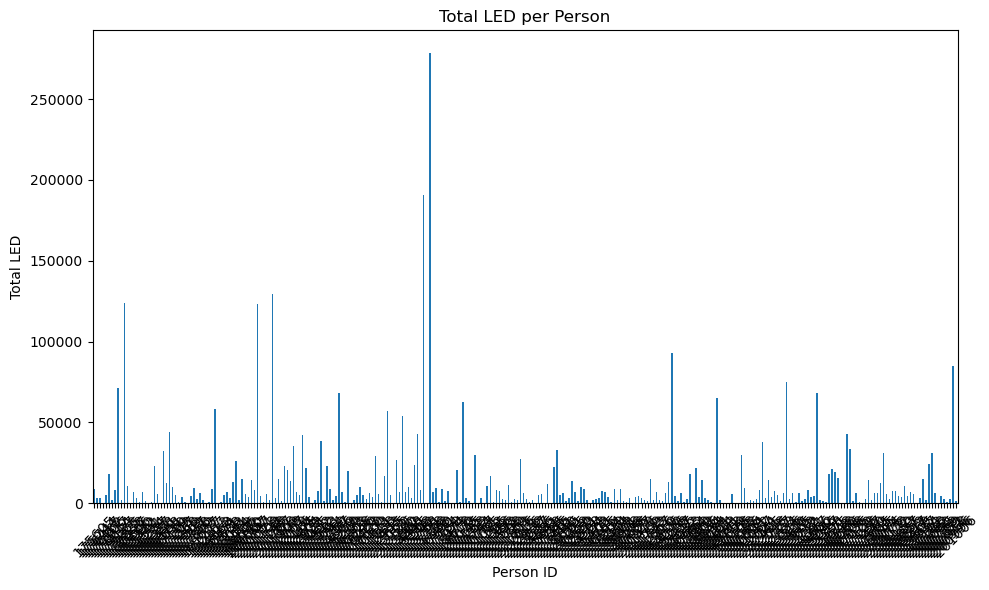

In [220]:
led_by_person = led_df.groupby('person_id')['led'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
led_by_person.plot(kind='bar')
plt.xlabel('Person ID')
plt.ylabel('Total LED')
plt.title('Total LED per Person')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [365]:
patient_stay = led_df.groupby('person_id')['drug_exposure_start_datetime'].agg(['min', 'max']).reset_index()
mean_led = led_df.groupby('person_id')['led'].mean().reset_index()
patient_stay['mean_led'] = mean_led['led']
patient_stay['stay'] = patient_stay['max'] - patient_stay['min']
patient_stay['stay_in_years'] = (patient_stay['max'] - patient_stay['min']) / np.timedelta64(1, 'Y')
patient_stay = patient_stay[['person_id', 'stay', 'stay_in_years', 'mean_led']].sort_values(by=['stay_in_years'], ascending=False)

In [366]:
patient_stay

,person_id,stay,stay_in_years,mean_led
111,216583,3348 days 19:06:00,9.168692,136.266748
229,253410,3308 days 21:15:00,9.059421,195.942408
98,213120,3169 days 17:29:00,8.678422,135.135135
104,215395,2974 days 14:46:00,8.144220,168.950820
142,222938,2901 days 22:36:00,7.945246,54.424569
...,...,...,...,...
3,176462,0 days 03:23:00,0.000386,100.000000
72,203402,0 days 02:23:00,0.000272,80.000000
213,250583,0 days 00:00:00,0.000000,100.000000
125,220744,0 days 00:00:00,0.000000,100.000000


In [385]:
years_of_stay = patient_stay[patient_stay['stay_in_years'] > 5]
years_of_stay_person_id = years_of_stay.index.tolist()

In [386]:
years_of_stay_person_id

[216583,
 253410,
 213120,
 215395,
 222938,
 243410,
 196471,
 257569,
 212715,
 209423,
 235373,
 249161,
 252548,
 220195,
 230650,
 215742,
 249691,
 249643,
 256708,
 245208,
 258899]

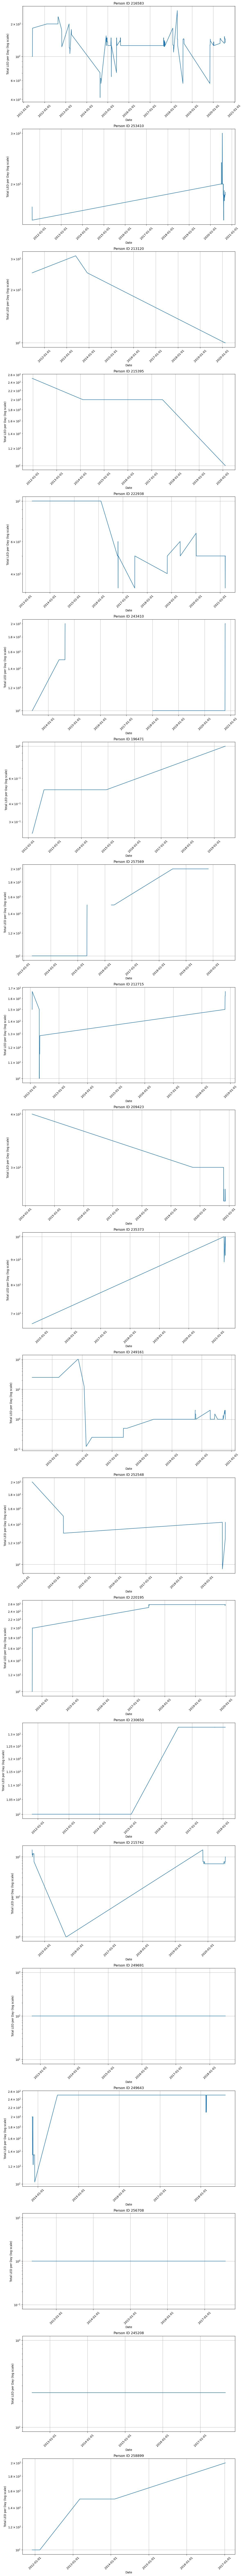

In [387]:
import matplotlib.dates as mdates

# Group by person and date, and calculate mean LED
led_by_person_date = led_df.groupby(['person_id', led_df['drug_exposure_start_datetime'].dt.date])['led'].mean().reset_index()

# Create individual subplots for each patient
fig, axes = plt.subplots(len(years_of_stay_person_id), 1, figsize=(12, 6 * len(years_of_stay_person_id)))

for i, person_id in enumerate(years_of_stay_person_id):
    person_data = led_by_person_date[led_by_person_date['person_id'] == person_id]
    
    ax = axes[i]
    ax.plot(person_data['drug_exposure_start_datetime'], person_data['led'])
    ax.set_title(f'Person ID {person_id}')
    
    # Set X-axis tick frequency and formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    
    # Set Y-axis to logarithmic scale
    ax.set_yscale('log')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Total LED per Day (log scale)')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)
    led_by_person_date
plt.tight_layout()
plt.show()

/tmp/ipykernel_25232/2865909839.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


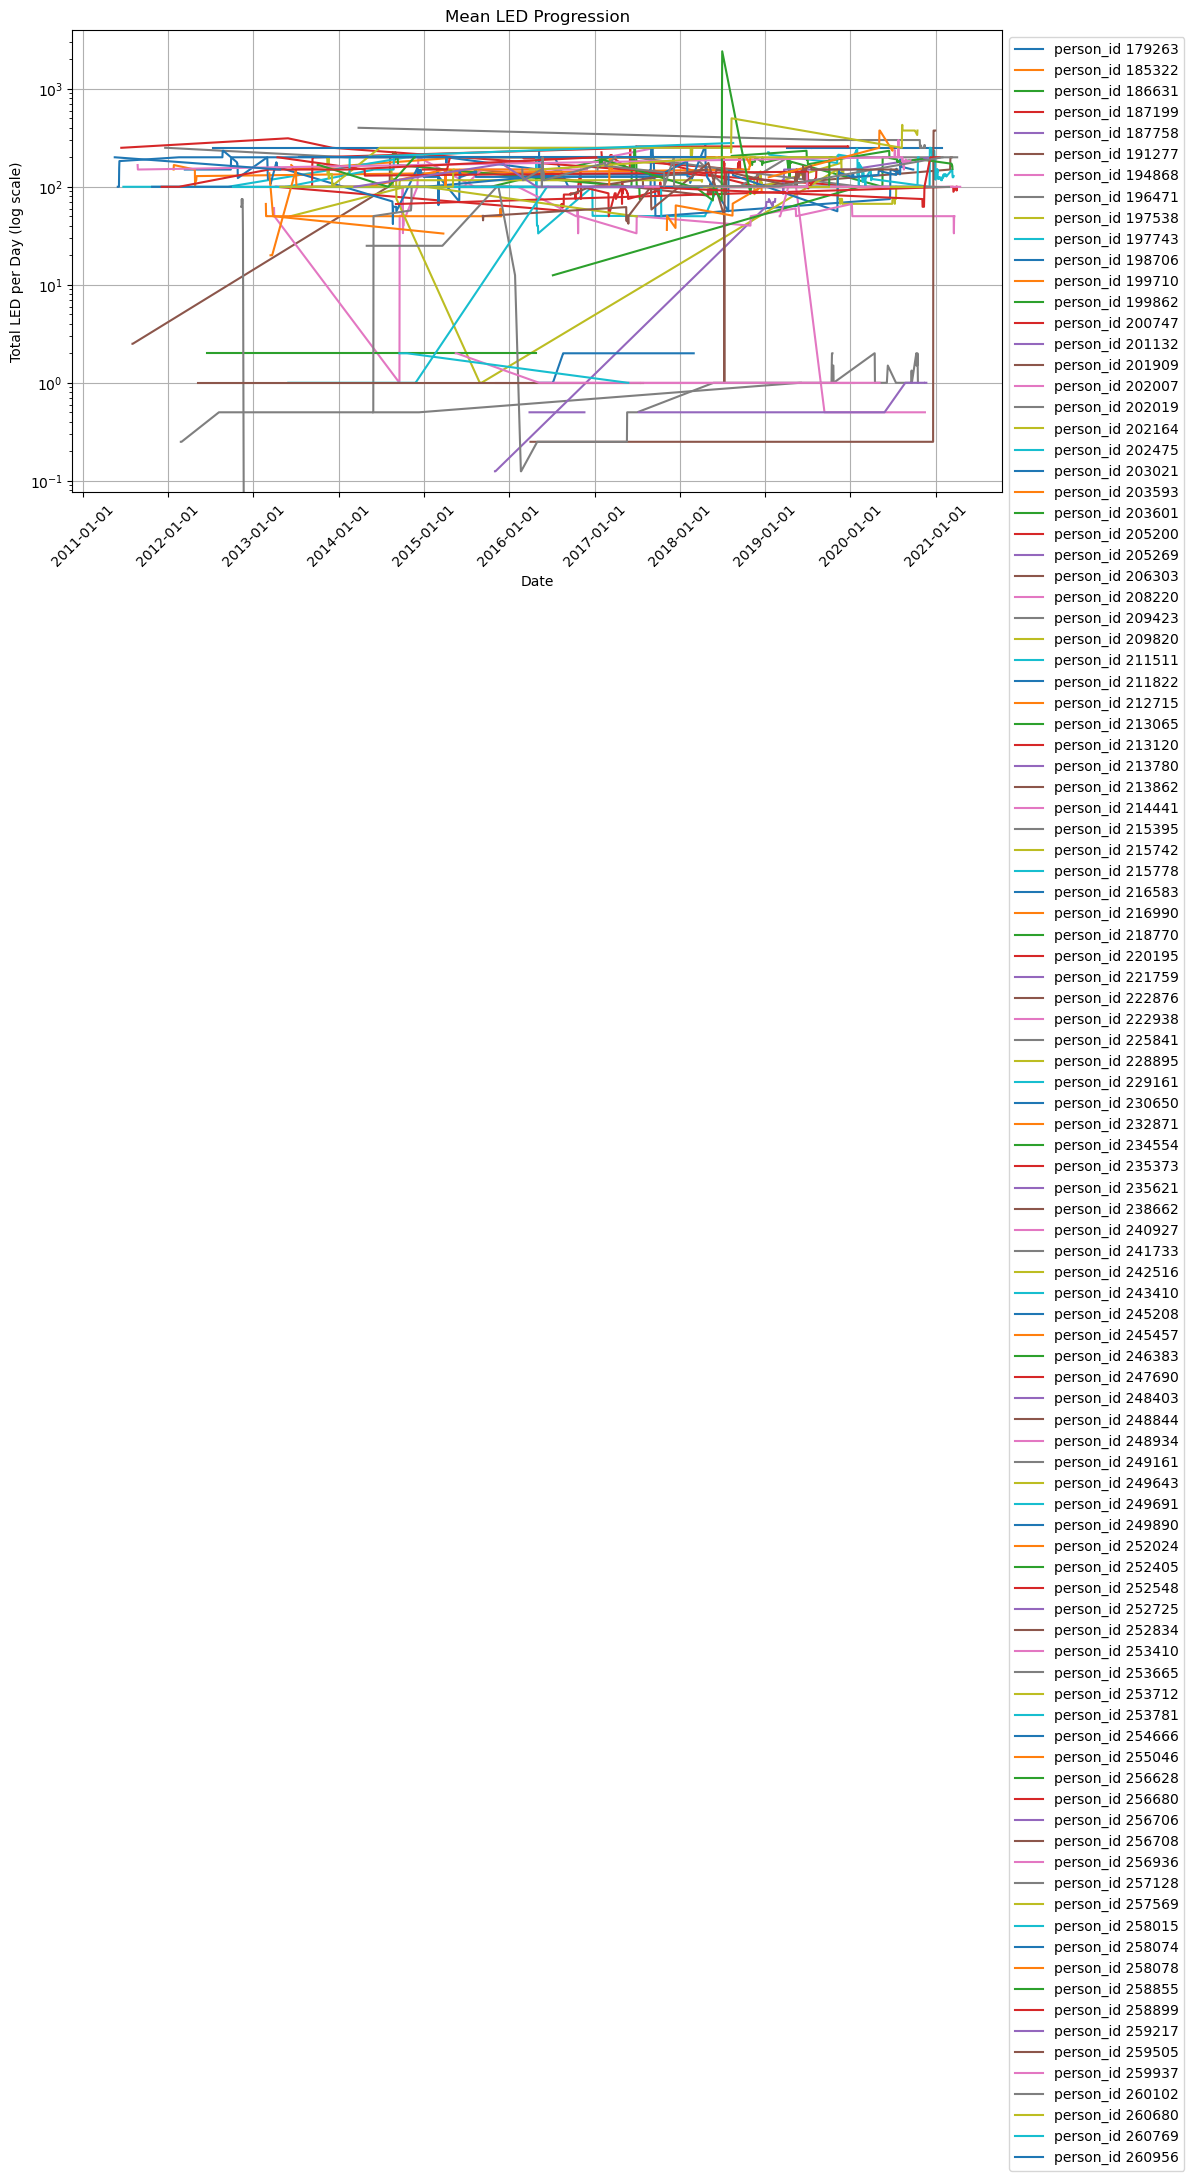

In [373]:
import matplotlib.dates as mdates

# Group by person and date, and calculate mean LED
led_by_person_date = led_df.groupby(['person_id', led_df['drug_exposure_start_datetime'].dt.date])['led'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))

for person_id, person_data in led_by_person_date.groupby('person_id'):
    if person_id in years_of_stay_person_id:
        plt.plot(person_data['drug_exposure_start_datetime'], person_data['led'], label=f'person_id {person_id}')

# Set X-axis tick frequency and formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set Y-axis to logarithmic scale
plt.yscale('log')

plt.xlabel('Date')
plt.ylabel('Total LED per Day (log scale)')
plt.title('Mean LED Progression')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


In [341]:
patient_stay[patient_stay.index == person_id_list[0]] 

,stay,stay_in_years
person_id,,
196471,2654 days 21:18:00,7.268835


In [340]:
led_df[led_df['person_id'] == person_id_list[0]].sort_values(by=['drug_exposure_start_datetime'])

,person_id,drug_exposure_start_datetime,drug_source_value,drug_info,generic_name,brand_name,dosage,led_dose,dose_source_value,dose_unit_source_value,route_source_value,visit_occurrence_id,visit_detail_id,led
23531,196471,2012-02-25 11:38:00,"{""med_display_name"": ""ropinirole (REQUIP) tabl...",ropinirole (REQUIP) tablet 0.5 mg,ropinirole,requip,0.5 mg,0.5,0.5,mg,ORAL,30981104,6888934.0,0.25
23532,196471,2012-02-26 08:56:00,"{""med_display_name"": ""ropinirole (REQUIP) tabl...",ropinirole (REQUIP) tablet 0.5 mg,ropinirole,requip,0.5 mg,0.5,0.5,mg,ORAL,30981104,6888934.0,0.25
23533,196471,2012-02-27 08:46:00,"{""med_display_name"": ""ropinirole (REQUIP) tabl...",ropinirole (REQUIP) tablet 0.5 mg,ropinirole,requip,0.5 mg,0.5,0.5,mg,ORAL,30981104,6888934.0,0.25
23534,196471,2012-02-28 01:07:00,"{""med_display_name"": ""ropinirole (REQUIP) tabl...",ropinirole (REQUIP) tablet 0.5 mg,ropinirole,requip,0.5 mg,0.5,0.5,mg,ORAL,30981104,6888937.0,0.25
23535,196471,2012-02-28 20:40:00,"{""med_display_name"": ""ropinirole (REQUIP) tabl...",ropinirole (REQUIP) tablet 0.5 mg,ropinirole,requip,0.5 mg,0.5,0.5,mg,ORAL,30981104,6888937.0,0.25
23536,196471,2012-08-06 21:48:00,"{""med_display_name"": ""ropinirole (REQUIP) tabl...",ropinirole (REQUIP) tablet 1 mg,ropinirole,requip,1 mg,1.0,1.0,mg,ORAL,30981105,6888938.0,0.50
23537,196471,2014-12-09 21:37:00,"{""med_display_name"": ""rOPINIRole (REQUIP) tabl...",rOPINIRole (REQUIP) tablet 1 mg,ropinirole,requip,1 mg,1.0,1.0,mg,ORAL,30981106,6888940.0,0.50
23538,196471,2014-12-10 08:28:00,"{""med_display_name"": ""rOPINIRole (REQUIP) tabl...",rOPINIRole (REQUIP) tablet 1 mg,ropinirole,requip,1 mg,1.0,1.0,mg,ORAL,30981106,6888940.0,0.50
23539,196471,2014-12-10 13:47:00,"{""med_display_name"": ""rOPINIRole (REQUIP) tabl...",rOPINIRole (REQUIP) tablet 1 mg,ropinirole,requip,1 mg,1.0,1.0,mg,ORAL,30981106,6888940.0,0.50
23540,196471,2014-12-10 20:40:00,"{""med_display_name"": ""rOPINIRole (REQUIP) tabl...",rOPINIRole (REQUIP) tablet 1 mg,ropinirole,requip,1 mg,1.0,1.0,mg,ORAL,30981106,6888940.0,0.50


In [223]:
led_by_person_date['person_id'].unique()

array([175605, 175744, 176417, 176462, 176706, 177917, 178614, 179137,
       179263, 179325, 179838, 180227, 180806, 185090, 185322, 185491,
       185591, 186234, 186247, 186327, 186338, 186491, 186588, 186631,
       186710, 187199, 187208, 187217, 187268, 187319, 187509, 187737,
       187758, 187800, 187893, 189637, 191277, 192187, 192413, 194868,
       195154, 196471, 197538, 197743, 198041, 198174, 198429, 198706,
       199582, 199710, 199862, 200707, 200747, 200851, 201023, 201109,
       201132, 201148, 201288, 201787, 201878, 201909, 201948, 202007,
       202019, 202116, 202164, 202475, 202804, 202932, 203021, 203035,
       203402, 203512, 203593, 203601, 203744, 203750, 203757, 204866,
       204959, 205200, 205269, 206133, 206303, 206828, 207746, 208220,
       209423, 209820, 210100, 210173, 211511, 211538, 211822, 212433,
       212715, 213065, 213120, 213526, 213780, 213862, 213868, 214441,
       215395, 215508, 215742, 215768, 215771, 215778, 215798, 216583,
      

In [224]:
len(led_by_person_date['person_id'].unique())

286

In [225]:
led_df[(led_df['person_id'] == 249161) & (led_df['drug_exposure_start_datetime'] > '2016-01-01') & (led_df['led'] > 0)]['generic_name'].unique()

array(['pramipexole', 'ropinirole'], dtype=object)

In [226]:
led_df['drug_exposure_start_datetime'].describe()
# Chec with matt for outpatient pdata.
# pt with at least 2 visits. Take ptslot led for each avg over visit, assign 0 or 1 if it wnt up or down.

/tmp/ipykernel_25232/3453580252.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  led_df['drug_exposure_start_datetime'].describe()


count                   26946
unique                  23520
top       2017-09-18 20:35:00
freq                        7
first     2011-05-18 17:35:00
last      2021-05-05 12:54:00
Name: drug_exposure_start_datetime, dtype: object

In [227]:
led_df[['person_id', 'visit_occurrence_id']].value_counts()

person_id  visit_occurrence_id
201787     31635638               725
179838     28594460               636
260996     40422547               506
205200     32021686               475
215778     33331299               463
                                 ... 
230359     34973002                 1
258074     39795071                 1
249161     37712552                 1
255046     39104304                 1
259217     40126218                 1
Length: 849, dtype: int64

In [228]:
led_df[led_df.groupby('person_id')['visit_occurrence_id'].transform('nunique') >= 2]

,person_id,drug_exposure_start_datetime,drug_source_value,drug_info,generic_name,brand_name,dosage,led_dose,dose_source_value,dose_unit_source_value,route_source_value,visit_occurrence_id,visit_detail_id,led
7,260996,2012-10-10 23:20:00,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,100.0,100.0,mg,ORAL,40422545,9880642.0,100.0
8,260996,2012-11-04 08:29:00,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,100.0,100.0,mg,ORAL,40422545,9865331.0,100.0
9,260996,2012-11-04 21:33:00,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,100.0,100.0,mg,ORAL,40422545,9865331.0,100.0
10,260996,2012-11-05 08:12:00,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,100.0,100.0,mg,ORAL,40422545,9865331.0,100.0
11,260996,2012-11-05 20:27:00,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,100.0,100.0,mg,ORAL,40422545,9865331.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26941,175605,2017-09-20 13:51:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,1.0,tablet,ORAL,27807633,6375345.0,100.0
26942,175605,2017-09-20 21:09:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,1.0,tablet,ORAL,27807633,6375345.0,100.0
26943,175605,2017-09-21 08:50:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,1.0,tablet,ORAL,27807633,6375345.0,100.0
26944,175605,2017-09-19 10:08:00,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,100.0,0.0,tablet,ORAL,27807633,6375345.0,NaN


In [229]:
led_df[led_df['person_id'] == 260996]['visit_occurrence_id'].unique()

array([40422545, 40422547, 40422548])

In [230]:
led_df.groupby('person_id')['visit_occurrence_id'].nunique().sort_values(ascending=False)

person_id
249161    25
256936    24
216583    21
256706    14
208220    12
          ..
235403     1
203512     1
203744     1
203757     1
261006     1
Name: visit_occurrence_id, Length: 286, dtype: int64

In [231]:
led_df[led_df['person_id'] == 176462].sort_values(by=['drug_exposure_start_datetime'])
# Plot visit lines. Find patients through the years, notes. unit for prediction (visit)

,person_id,drug_exposure_start_datetime,drug_source_value,drug_info,generic_name,brand_name,dosage,led_dose,dose_source_value,dose_unit_source_value,route_source_value,visit_occurrence_id,visit_detail_id,led
26722,176462,2015-06-10 10:08:00,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",pramipexole (MIRAPEX) tablet 1 mg,pramipexole,mirapex,1 mg,1.0,1.0,mg,ORAL,28045216,6408634.0,100.0
26721,176462,2015-06-10 13:31:00,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",pramipexole (MIRAPEX) tablet 1 mg,pramipexole,mirapex,1 mg,1.0,1.0,mg,ORAL,28045216,6408634.0,100.0


In [232]:
led_by_person.sort_values(ascending=False)

person_id
216583    278665.500
215778    190802.000
201787    129164.875
179838    123600.000
201023    122980.000
             ...    
249614         8.500
215798         6.000
220761         0.000
221162         0.000
192187         0.000
Name: led, Length: 286, dtype: float64